<a href="https://colab.research.google.com/github/huyphuong99/ocr_crnn_ctc_birthday/blob/main/CRNN_CTC_data_birthday.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = "birthday"


In [4]:
!mkdir /content/data
!mkdir ./data/file_padding
!cp /content/drive/MyDrive/tima/recognition_OCR/Data/{data}.zip /content/data

!unzip /content/data/{data}.zip -d /content/data 


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: /content/data/birthday/birthday/issue_date03063_9549189_1136848.jpeg  
  inflating: /content/data/birthday/birthday/issue_date03077_9549323_1146864.jpg  
  inflating: /content/data/birthday/birthday/issue_date03089_9549452_1148074.jpeg  
  inflating: /content/data/birthday/birthday/issue_date03135_9550053_1146069.jpg  
  inflating: /content/data/birthday/birthday/issue_date03169_9550555_1149739.jpg  
  inflating: /content/data/birthday/birthday/issue_date03189_9550734_1147048.jpg  
  inflating: /content/data/birthday/birthday/issue_date03192_9550808_1149484.jpg  
  inflating: /content/data/birthday/birthday/issue_date03224_9551178_1141460.jpg  
  inflating: /content/data/birthday/birthday/issue_date03275_9551830_1152695.jpg  
  inflating: /content/data/birthday/birthday/issue_date03318_9552356_1152754.jpg  
  inflating: /content/data/birthday/birthday/issue_date03337_9552540_1149170.jpg  
  inflating: /content/data/b

In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
 
from pathlib import Path
from collections import Counter
 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
import glob
import pandas as pd
import cv2 as cv

In [6]:
batch_size = 16
img_height = 40
img_width = 880
max_len = 8

In [7]:
NULL_CHAR = '<nul>'
characters = "0123456789"
# characters = characters.upper() # Chỉ lấy chữ viết hoa vì trong tập dữ liệu họ tên cmnd chỉ có chữ viết hoa.
# characters = set(characters) # loại bỏ những ký tự lặp lại
characters = sorted(characters) # sort lại vì vừa gọi hàm set làm mất thứ tự
characters.append(NULL_CHAR)
characters.append(" ")
characters

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '<nul>', ' ']

In [8]:
# images = sorted(list(map(str, list(data_dir.glob("*.png")))))
# labels = [img.split("/")[-1].split("_")[-1].replace(".png", "") for img in images]

images = []
labels = []
file_birth = pd.read_csv("data/birthday/birthday.csv",  dtype={"label": str})
# print(file_birth)
file_name = list(file_birth["filename"])
file_label = list(str(i) for i in file_birth["label"])

# print(file_name[1052])
# print(file_label[1052])

for file in glob.glob("./data/birthday/birthday/*"):
    filename = os.path.basename(file)
    # print(filename)
    # labels.append(filename)
    if filename in file_name:
      images.append(file)
      label =  file_label[file_name.index(filename)]
      label_padded = [NULL_CHAR] * max_len
      label_padded[:len(label)] = label
      labels.append(label_padded)  
      
print("Number of images found: ",len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
# print("Characters present: ", characters)


t = 0
for k in range(len(characters)):
  count = 0
  for i in range(len(labels)):
    for j in range(len(labels[i])):
      if characters[k] == labels[i][j]:
        count += 1
  print('',characters[k],' : ',count)
  t += count
print(t)

Number of images found:  6604
Number of labels found:  6604
Number of unique characters:  12
 0  :  13400
 1  :  11672
 2  :  11201
 3  :  1672
 4  :  1310
 5  :  1394
 6  :  1605
 7  :  1929
 8  :  2506
 9  :  5396
 <nul>  :  746
    :  0
52831


In [9]:
data_dir = Path("./data/birthday/birthday")
list_img = glob.glob(os.path.join(data_dir, "*"))
dict_img = {}
# images = []
for file in list_img:
  file_name = os.path.basename(file)
  img = cv.imread(file)
  height, width = img.shape[:2]
  dict_img[file_name] = [height, width]
#   img = cv.resize(img,(100, 50), interpolation = cv.INTER_AREA)
#   cv.imwrite(os.path.join("./data/resize_name/", file_name), img)

# print(dict_img)
df = pd.DataFrame(dict_img)
df_T = df.transpose()
df_T.columns = ["Height", "Width"]
df_T['rate'] = df_T['Width'] / df_T['Height']

df_describe = df_T.describe()

print("Describe of data:\n", df_describe)
print(len(images))



Describe of data:
             Height        Width         rate
count  6627.000000  6627.000000  6627.000000
mean     41.465218   320.205825     7.836255
std      18.637100   172.471621     2.772613
min      11.000000    67.000000     2.517241
25%      26.000000   200.000000     5.304348
50%      40.000000   264.000000     7.369565
75%      51.000000   440.000000    10.441860
max     149.000000  1115.000000    21.857143
6604


In [10]:

#ADD PADDING AND RESIZE IMAGES

def add_padding(image, img_w = 880, img_h = 40):
  img = cv.imread(image)
  name = os.path.basename(image)
  hh, ww, cc = img.shape
  rate = ww/hh
  img = cv.resize(img, (round(rate*img_h),img_h), interpolation = cv.INTER_AREA) #INTER_AREA is interpolation method
  color = (0,0,0)
  result = np.full((img_h, img_w, cc), color, dtype=np.uint8)
  # print(rate)
  result[:img_h, :round(rate * img_h)] = img

  cv.imwrite("/content/data/file_padding/" + name,result)
  # plt.imshow(result)
  # plt.show()
# print(len(images))
for i in images:
  add_padding(i)

In [11]:

images = []
for file in glob.glob("./data/file_padding/*"):
  # print(file)
  images.append(file)
print((images))


['./data/file_padding/issue_date03725_9557056_1155363.jpeg', './data/file_padding/07679_9606971_1179238_0.jpg', './data/file_padding/second_date01714_9530594_1125813.jpg', './data/file_padding/issue_date00615_9515795_1129662.jpg', './data/file_padding/02285_9539093_1144339.jpg', './data/file_padding/third_date02134_9536685_1143567.jpg', './data/file_padding/second_date03382_9553101_1145454.jpg', './data/file_padding/00168_9509867_1130171_0.jpg', './data/file_padding/issue_date00658_9516336_1128475.jpg', './data/file_padding/second_date00980_9520723_1133831.jpg', './data/file_padding/third_date01081_9522163_1134790.jpg', './data/file_padding/issue_date01944_9533788_1140188.jpg', './data/file_padding/00795_9517919_1133241.jpg', './data/file_padding/13245_9682522_1219903.jpeg', './data/file_padding/04015_9560878_1150812_0.jpg', './data/file_padding/04585_9567836_1159881.jpg', './data/file_padding/third_date04810_9570463_1162182.jpg', './data/file_padding/05221_9575255_1163979_0.jpg', './d

In [12]:
# data_dir = Path("./data/resize_name/")
# images = sorted(list(map(str, list(data_dir.glob("*.png")))))

# img = cv.imread("./data/NAME/1001_2_TƯ.png")
# img = cv.resize(img,(100, 50), interpolation = cv.INTER_AREA)
# plt.imshow(img)
# plt.show()
# print(images)
# print(len(labels))
def split_data(imgs, labels, train_size=0.9):
    size = len(imgs)
    train_sample = int(size * train_size)
    x_train, y_train = imgs[:train_sample], labels[:train_sample]
    x_valid, y_valid = imgs[train_sample:], labels[train_sample:]
    return x_train, y_train, x_valid, y_valid

x_train, y_train, x_valid, y_valid = split_data(np.array(images), np.array(labels))
print(labels)
# print(np.array(labels))

# x = list(map(lambda xx: np.array(xx), labels))
# x = np.array(x)
# print(x)


[['0', '1', '0', '9', '2', '0', '1', '1'], ['0', '8', '1', '2', '1', '9', '8', '9'], ['1', '1', '0', '1', '2', '0', '1', '7'], ['1', '8', '0', '6', '2', '0', '1', '3'], ['0', '2', '1', '2', '2', '0', '2', '0'], ['0', '1', '1', '2', '2', '0', '2', '0'], ['2', '4', '1', '2', '2', '0', '1', '3'], ['2', '9', '0', '3', '1', '9', '9', '1'], ['1', '2', '5', '2', '0', '2', '0', '<nul>'], ['0', '7', '0', '8', '2', '0', '1', '7'], ['2', '8', '1', '1', '2', '0', '2', '0'], ['2', '3', '0', '3', '2', '0', '1', '6'], ['2', '7', '1', '1', '2', '0', '2', '0'], ['0', '4', '0', '1', '2', '0', '2', '0'], ['3', '0', '0', '1', '1', '9', '8', '6'], ['0', '8', '1', '2', '2', '0', '2', '0'], ['0', '9', '1', '2', '2', '0', '2', '0'], ['0', '3', '0', '4', '1', '9', '9', '3'], ['2', '9', '1', '1', '2', '0', '2', '0'], ['1', '0', '0', '6', '1', '9', '7', '5'], ['1', '2', '0', '2', '2', '0', '0', '0'], ['0', '7', '0', '1', '1', '9', '9', '3'], ['2', '6', '1', '1', '2', '0', '2', '0'], ['3', '0', '0', '3', '2', '0'

In [13]:
x_train, y_train, len(x_train), len(y_train)

(array(['./data/file_padding/issue_date03725_9557056_1155363.jpeg',
        './data/file_padding/07679_9606971_1179238_0.jpg',
        './data/file_padding/second_date01714_9530594_1125813.jpg', ...,
        './data/file_padding/third_date04280_9563830_1158000.jpg',
        './data/file_padding/third_date03698_9556760_1150221.jpg',
        './data/file_padding/07884_9609377_1181289.jpeg'], dtype='<U57'),
 array([['0', '1', '0', ..., '0', '1', '1'],
        ['0', '8', '1', ..., '9', '8', '9'],
        ['1', '1', '0', ..., '0', '1', '7'],
        ...,
        ['7', '1', '2', ..., '2', '0', '<nul>'],
        ['0', '4', '1', ..., '0', '2', '0'],
        ['1', '6', '1', ..., '0', '2', '0']], dtype='<U5'),
 5943,
 5943)

In [14]:
len(x_valid), len(y_valid)

(661, 661)

In [15]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=1, mask_token=''
)

print(char_to_num)
# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), invert=True
)

def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)

    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    print(label)
    # # 6. Map the characters in label to numbers
    label = char_to_num(label)
    
    # 7. Return a dict as our model is expecting two inputs
    
    return {"image": img, "label": label}

# print(x_valid)
y_valid[:30]

array([['1', '4', '0', '3', '1', '9', '9', '8'],
       ['1', '7', '1', '2', '1', '9', '8', '7'],
       ['0', '4', '0', '9', '2', '0', '1', '9'],
       ['2', '8', '1', '1', '2', '0', '2', '0'],
       ['1', '0', '0', '8', '1', '9', '9', '4'],
       ['0', '5', '1', '2', '2', '0', '2', '0'],
       ['1', '5', '0', '2', '1', '9', '9', '1'],
       ['0', '8', '0', '9', '1', '9', '7', '9'],
       ['0', '3', '1', '2', '2', '0', '2', '0'],
       ['0', '1', '1', '2', '2', '0', '2', '0'],
       ['1', '4', '0', '9', '2', '0', '1', '8'],
       ['1', '4', '0', '7', '2', '0', '2', '0'],
       ['1', '4', '0', '1', '1', '9', '9', '9'],
       ['2', '6', '1', '1', '2', '0', '2', '0'],
       ['0', '1', '1', '2', '2', '0', '2', '0'],
       ['3', '1', '1', '2', '2', '0', '2', '0'],
       ['0', '2', '0', '3', '2', '0', '2', '0'],
       ['2', '5', '0', '2', '1', '9', '9', '4'],
       ['0', '4', '1', '2', '2', '0', '2', '0'],
       ['1', '9', '8', '0', '<nul>', '<nul>', '<nul>', '<nul>'],
    

# Load data 

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
  train_dataset.map(
      encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)) # take  a tensor 
validation_dataset = (
    validation_dataset.map(
      encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE #Tune training process obtained efficiency
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

Tensor("args_1:0", shape=(8,), dtype=string)
Tensor("args_1:0", shape=(8,), dtype=string)


# Display images in a batch

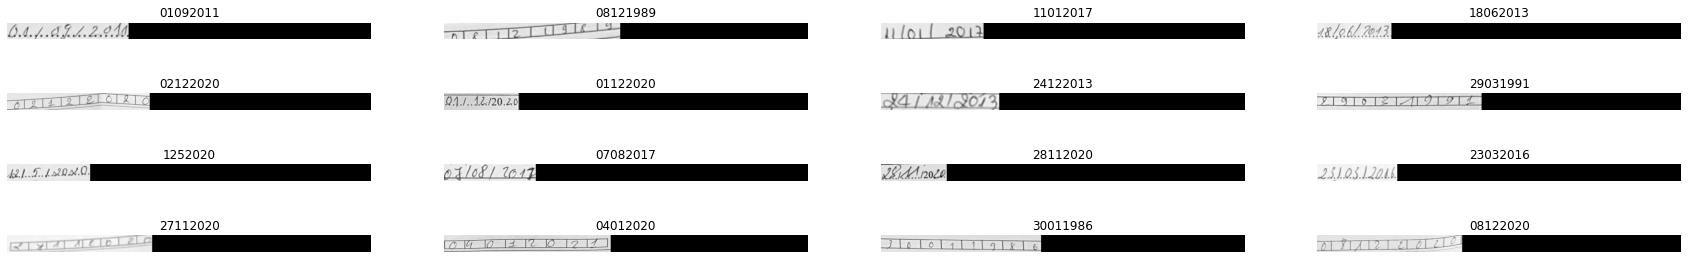

In [17]:
_, ax = plt.subplots(4, 4, figsize=(30,5))

for batch in train_dataset.take(1):
  images = batch["image"]
  labels = batch["label"]
  # print(labels)
  for i in range(16):
    img = (images[i] * 255).numpy().astype("uint8")
    label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
    label = label.replace(NULL_CHAR, "")
    # print(len(label), label)
    ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
    ax[i // 4, i % 4].set_title(label)
    ax[i // 4, i % 4].axis("off")
plt.show()

# Build Model CRNN



In [18]:
class CTCLayer(layers.Layer):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.loss_fn = keras.backend.ctc_batch_cost

  def call(self, y_true, y_pred):
    # Compute the training-time loss value and add it
    # to the layer using `self.add_loss()`.
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = self.loss_fn(y_true, y_pred, input_length, label_length)
    self.add_loss(loss)

    # At test time, just return the computed predictions
    return y_pred
 

def model_orig(input_img):
  # First conv block
  x = layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1",)(input_img)
  x = layers.MaxPooling2D((2, 2), name="pool1")(x)
  x = layers.BatchNormalization()(x)

  x = layers.Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv3",)(x)
  x = layers.MaxPooling2D((2, 2), name="pool3")(x)
  x = layers.BatchNormalization()(x)

  # Second conv block
  x = layers.Conv2D(256, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv2",)(x)
  x = layers.MaxPooling2D((2, 2), name="pool2")(x)
  x = layers.BatchNormalization()(x)
  # print(x)
  return x


def build_model():
  #Inputs to the model
  input_img = layers.Input(
      shape=(img_width, img_height, 1), name="image", dtype="float32"
  )

  labels = layers.Input(name="label", shape=(None,), dtype="float32")
  print("input_img: ",input_img)
  print("labels: ", labels)
  x = model_orig(input_img)

  # x = vgg_16(input_img)
  # x = vgg_19(input_img)

  new_shape = ((img_width // 8), (img_height // 8) * 256)
  x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
  x = layers.Dense(64, activation="relu", name="dense1")(x)
  x = layers.Dropout(0.25)(x)

  # RNNs
  x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
  x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

  # Output layer
  x = layers.Dense(len(characters) + 1, activation="softmax", name="dense2")(x)
  
  # Add CTC layer for calculating CTC loss at each step
  output = CTCLayer(name="ctc_loss")(labels, x)

  # Define the model
  model = keras.models.Model(
      inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
  )

  # Optimizer
  opt = keras.optimizers.Adam()
  
  # Compile the model and return
  model.compile(optimizer=opt)
  return model
model = build_model()
model.summary()

input_img:  KerasTensor(type_spec=TensorSpec(shape=(None, 880, 40, 1), dtype=tf.float32, name='image'), name='image', description="created by layer 'image'")
labels:  KerasTensor(type_spec=TensorSpec(shape=(None, None), dtype=tf.float32, name='label'), name='label', description="created by layer 'label'")
Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 880, 40, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 880, 40, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 440, 20, 32)  0           Conv1[0][0] 

## Training   

In [57]:
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
        "./data/file_padding",
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode="categorical")

Found 0 images belonging to 0 classes.


In [ ]:
epochs = 100
early_stopping_patience = 10
# Add early stoppingima
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
) 

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)



Epoch 1/100
372/372 [==============================] - 22s 60ms/step - loss: 0.9195 - val_loss: 0.9688
Epoch 2/100
372/372 [==============================] - 23s 61ms/step - loss: 0.5593 - val_loss: 0.8430
Epoch 3/100
372/372 [==============================] - 22s 60ms/step - loss: 0.4497 - val_loss: 0.8262
Epoch 4/100
372/372 [==============================] - 23s 61ms/step - loss: 0.4405 - val_loss: 0.7512
Epoch 5/100
372/372 [==============================] - 22s 60ms/step - loss: 0.4142 - val_loss: 0.8266
Epoch 6/100
372/372 [==============================] - 22s 60ms/step - loss: 0.4445 - val_loss: 0.9794
Epoch 7/100
372/372 [==============================] - 22s 60ms/step - loss: 0.4621 - val_loss: 0.7980
Epoch 8/100
372/372 [==============================] - 22s 60ms/step - loss: 0.4023 - val_loss: 1.1106
Epoch 9/100
308/372 [=======================>......] - ETA: 3s - loss: 0.3931

In [21]:
model.save_weights('./my_model.h5')

  ## Loss chart

53


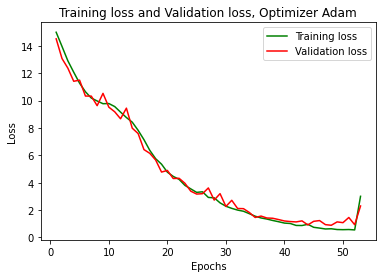

In [22]:
loss_train = np.array(history.history['loss'])
loss_val = np.array(history.history['val_loss'])
print(len(loss_train))
epochs = range(1,len(loss_train)+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'r', label='Validation loss')
plt.title('Training loss and Validation loss, Optimizer Adam')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
def load_trained_model(weight_path):
    model = build_model()
    model.load_weights(weight_path)
load_trained_model("./my_model_2.h5")

input_img:  KerasTensor(type_spec=TensorSpec(shape=(None, 880, 40, 1), dtype=tf.float32, name='image'), name='image', description="created by layer 'image'")
labels:  KerasTensor(type_spec=TensorSpec(shape=(None, None), dtype=tf.float32, name='label'), name='label', description="created by layer 'label'")


OSError: ignored

# Predict 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


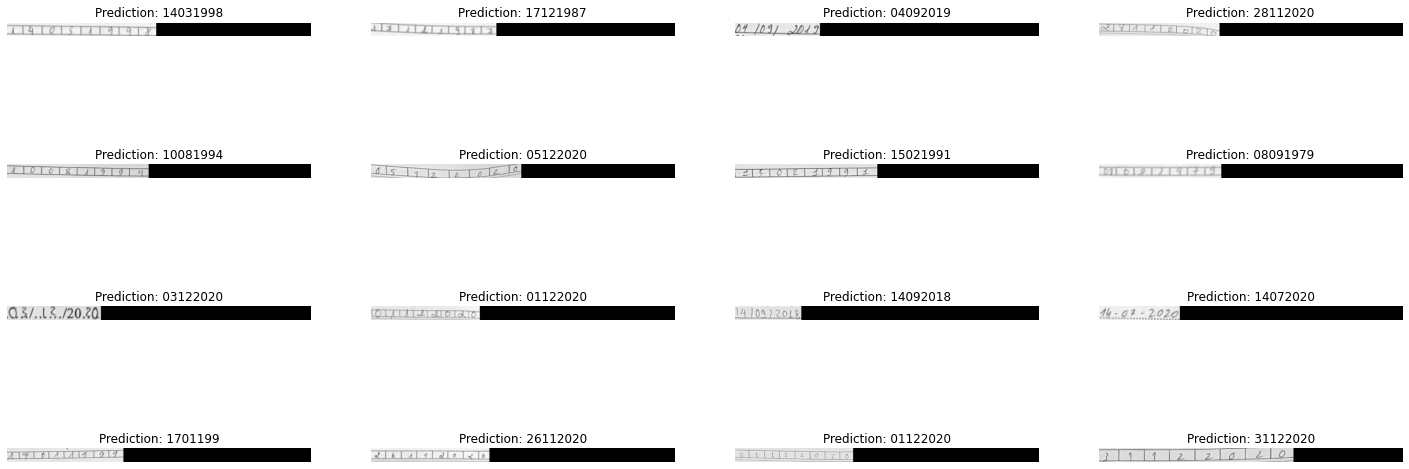

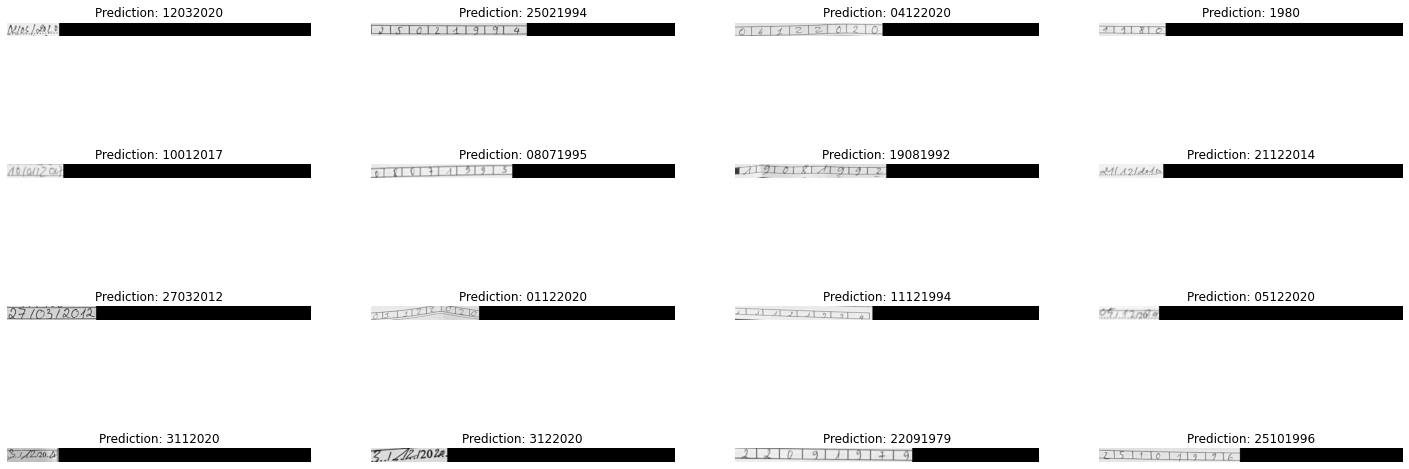

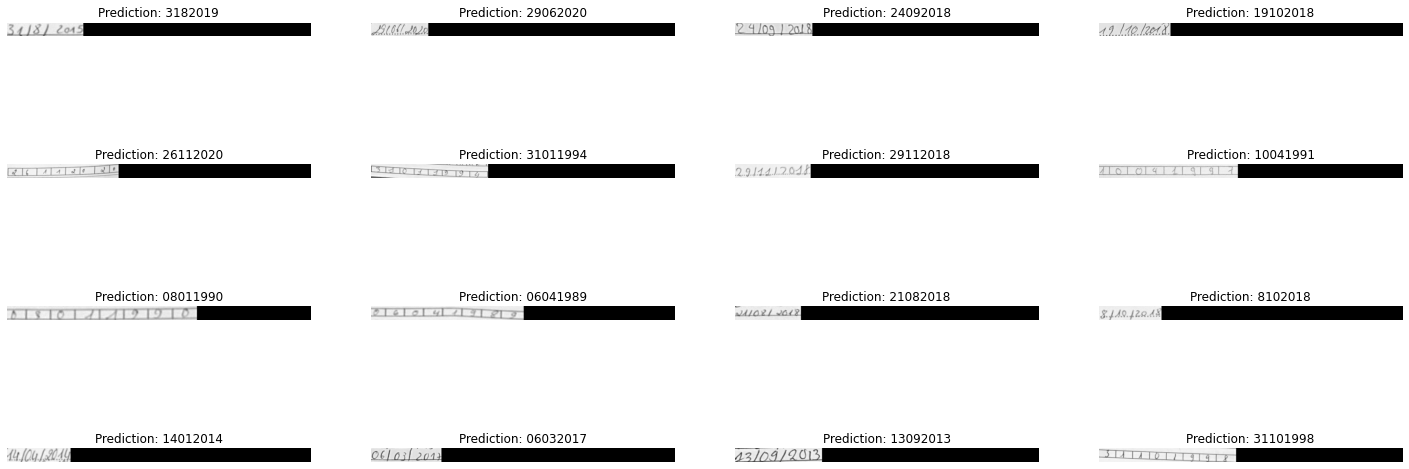

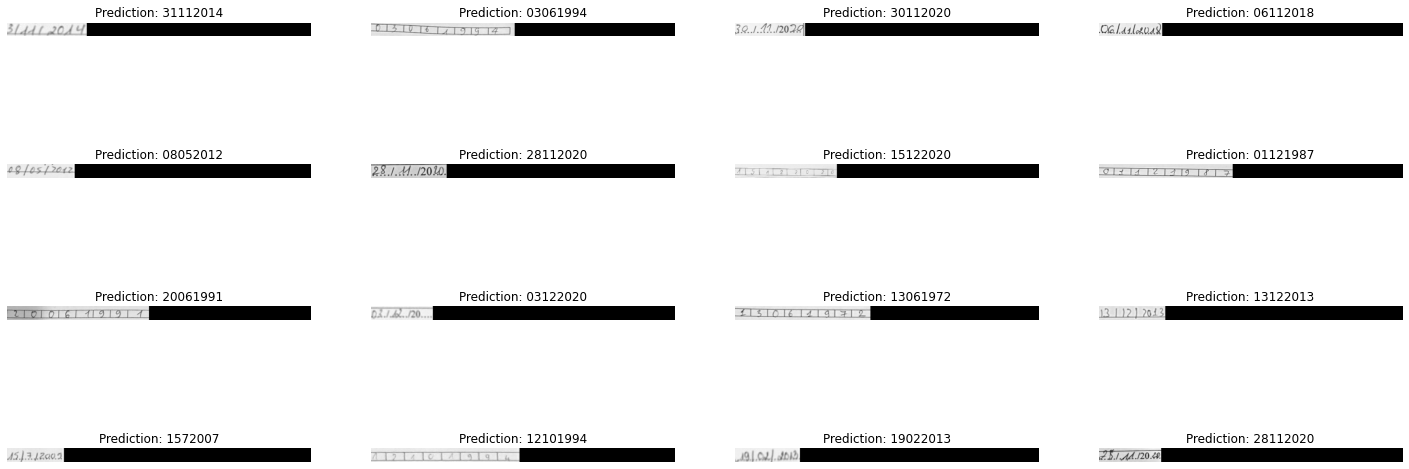

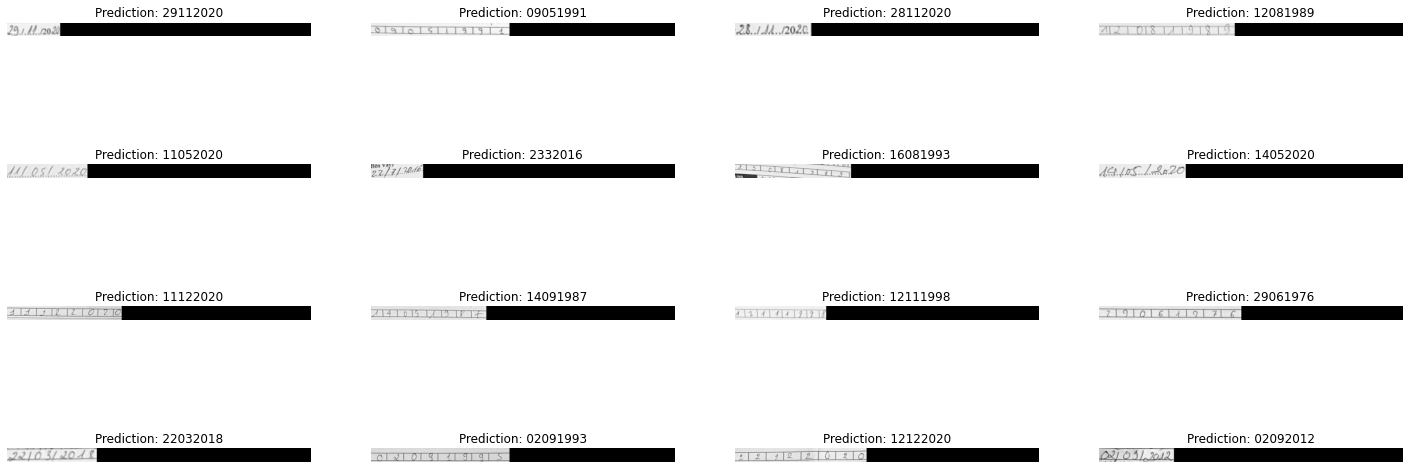

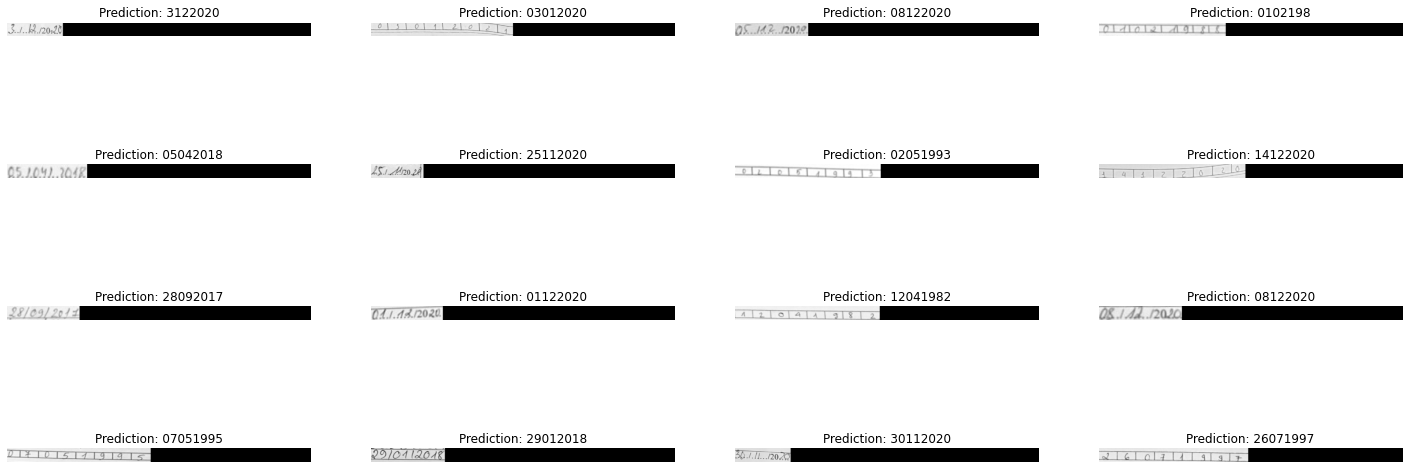

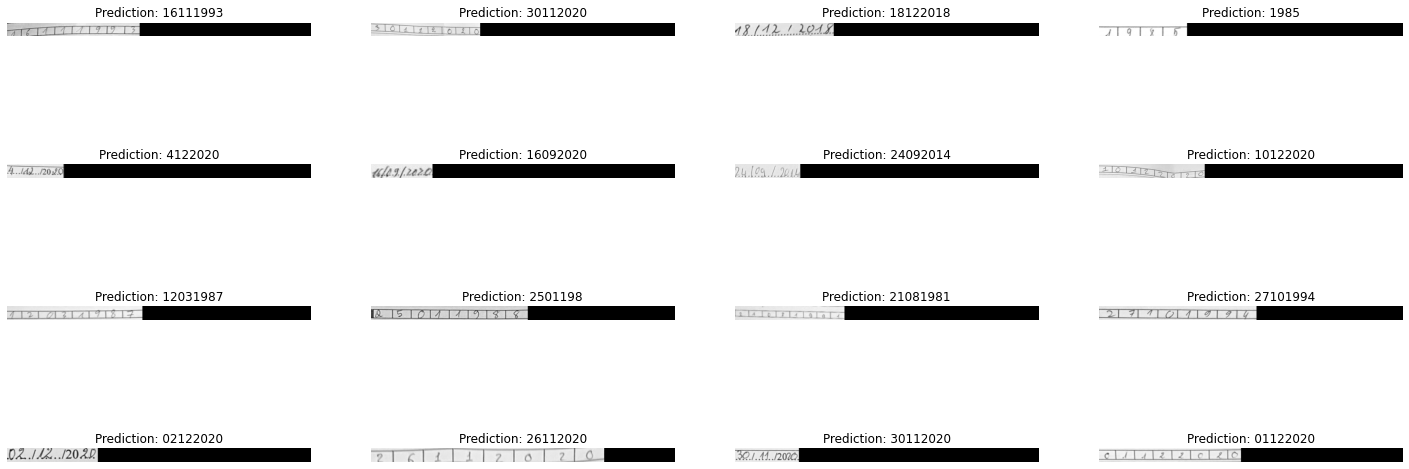

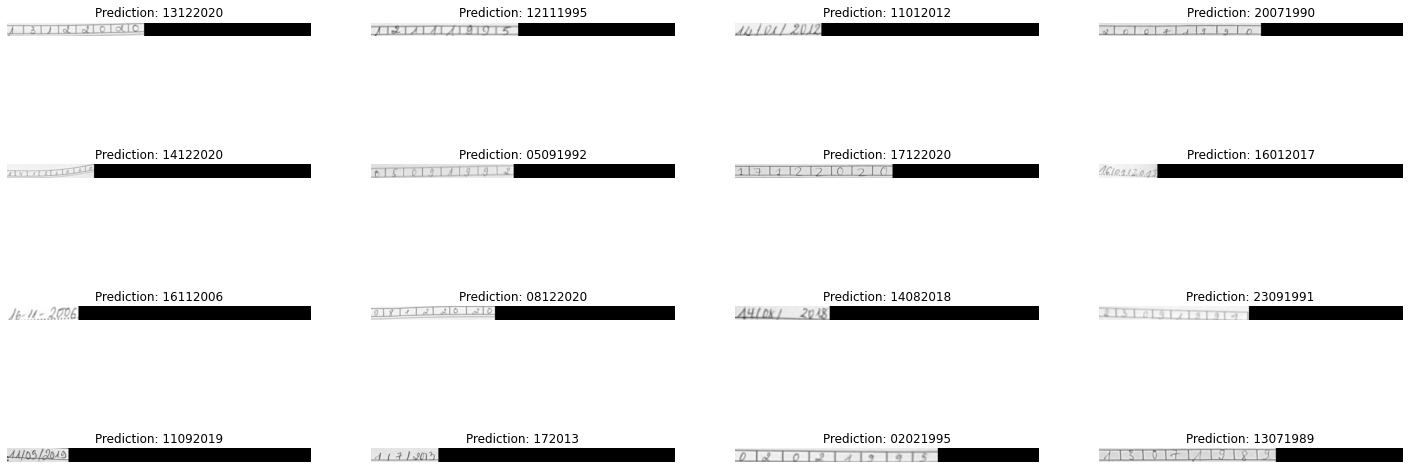

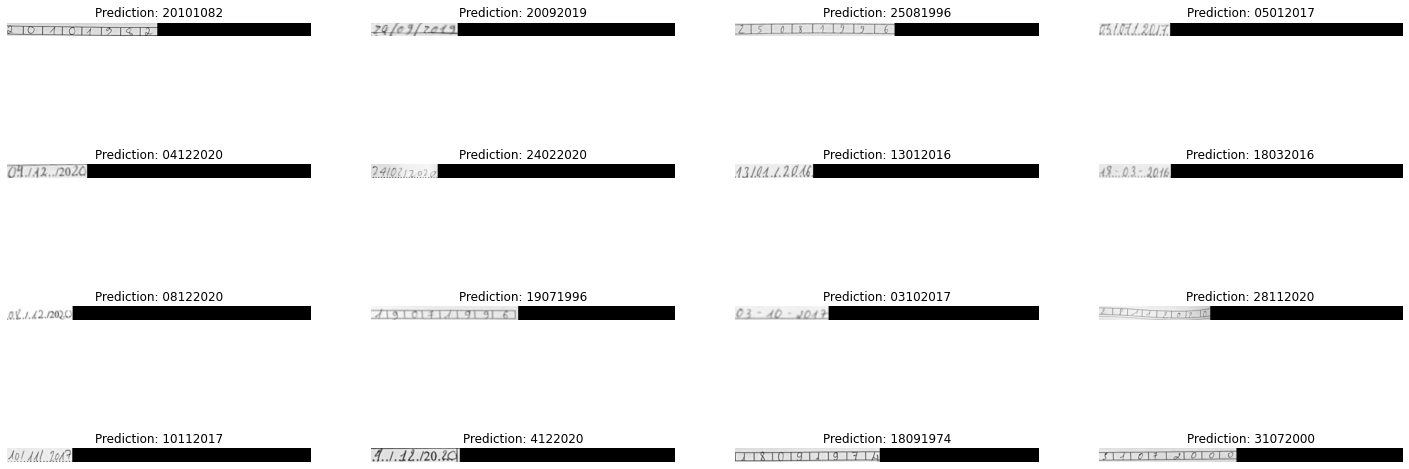

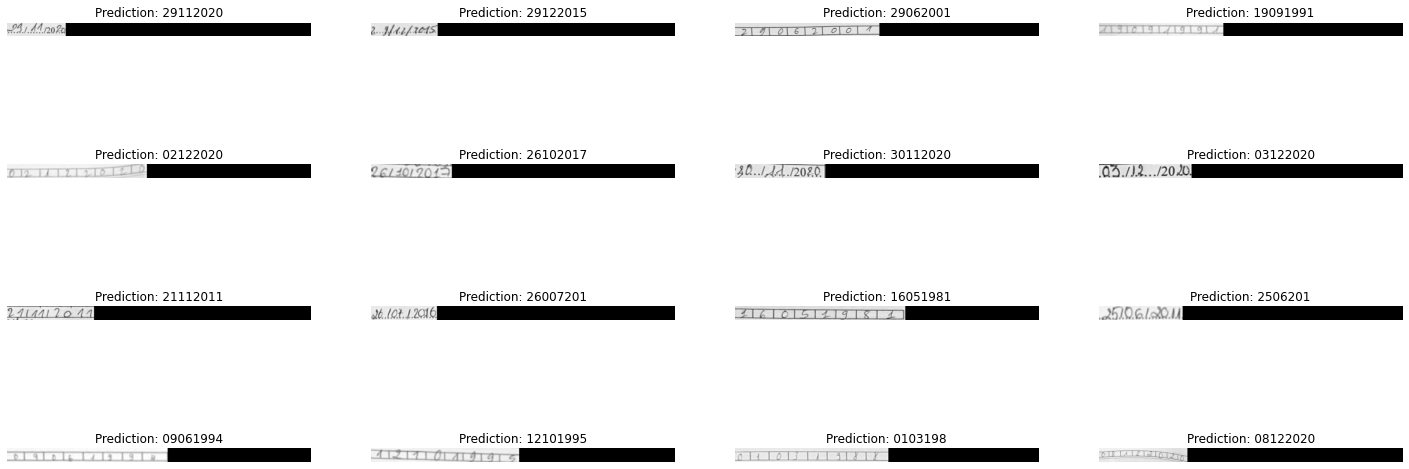

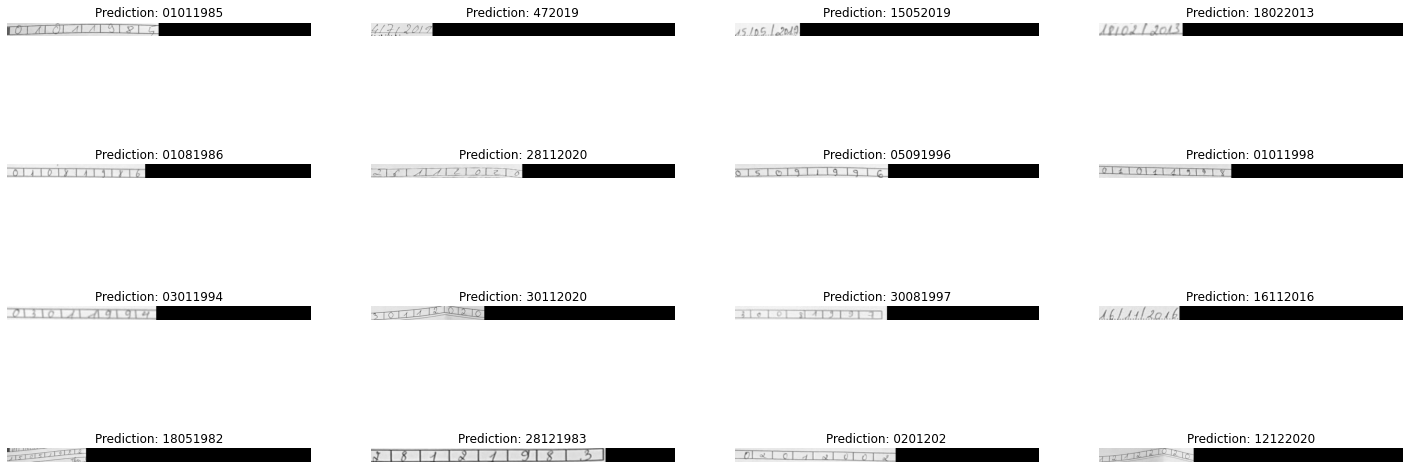

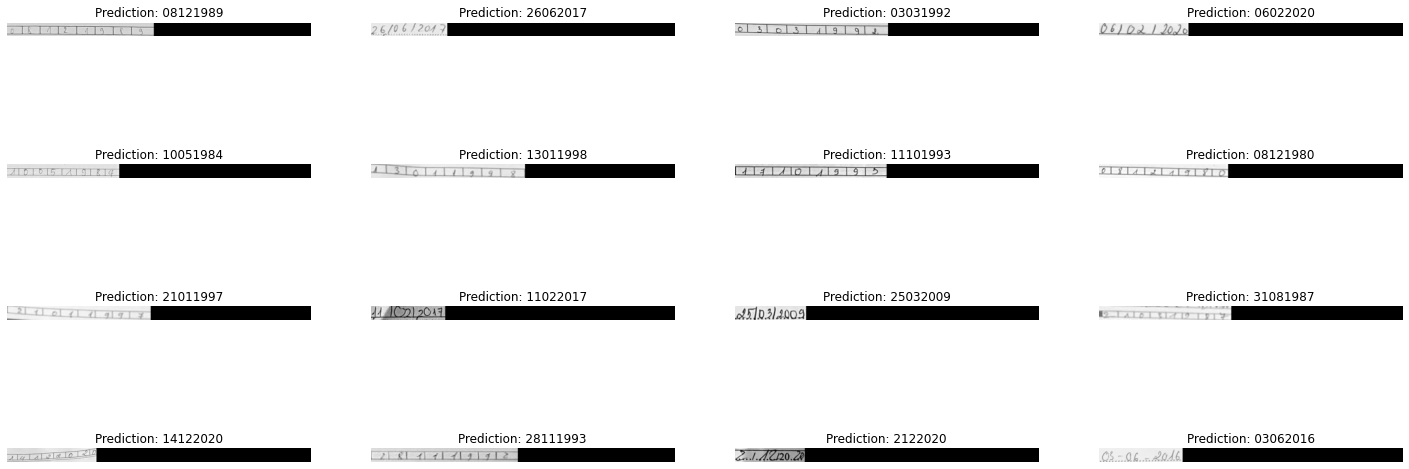

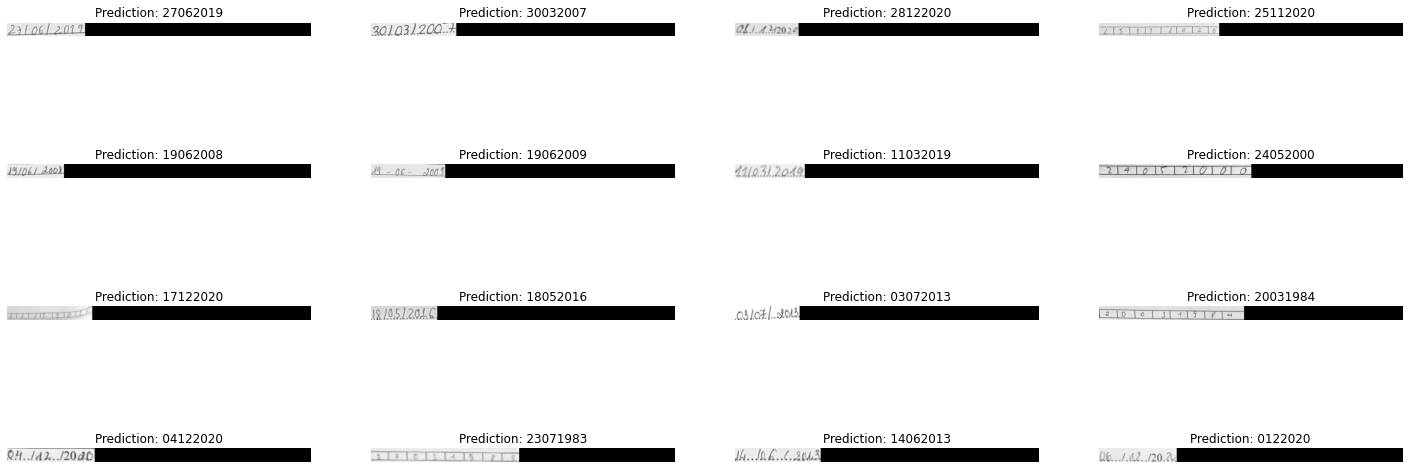

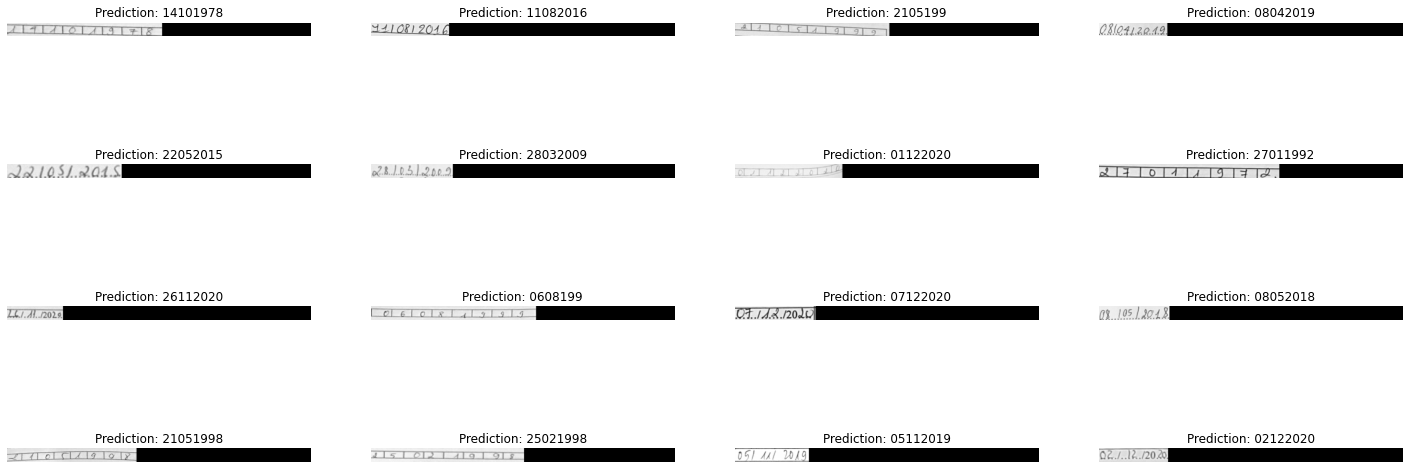

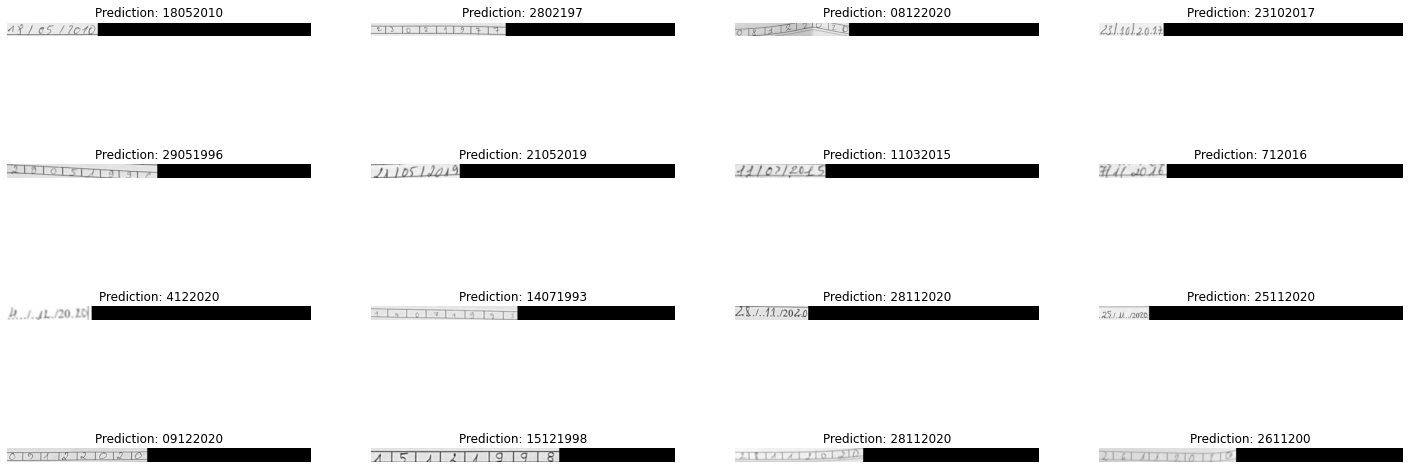

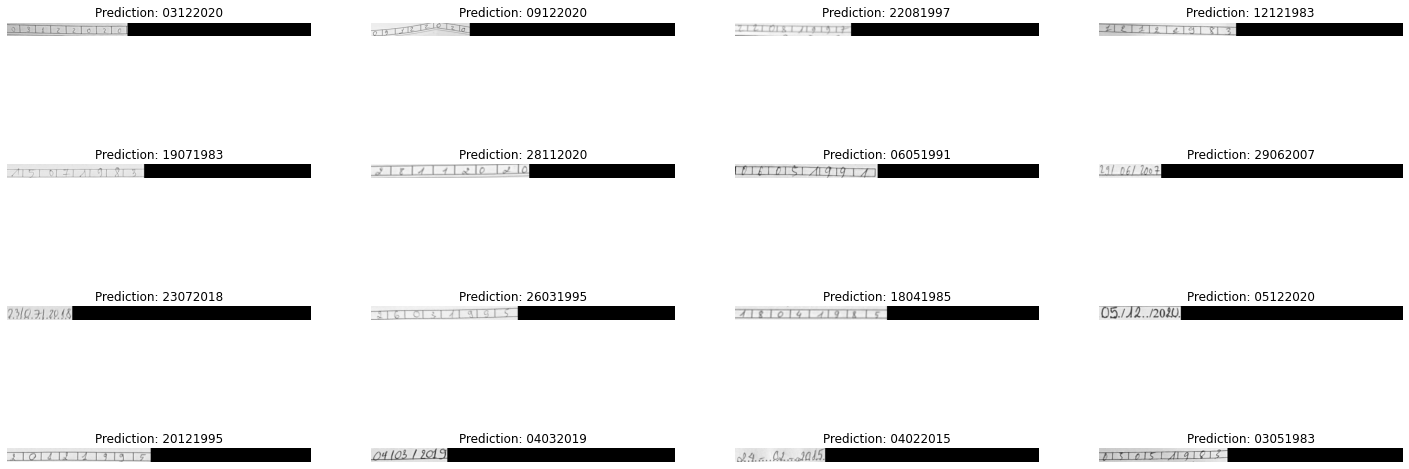

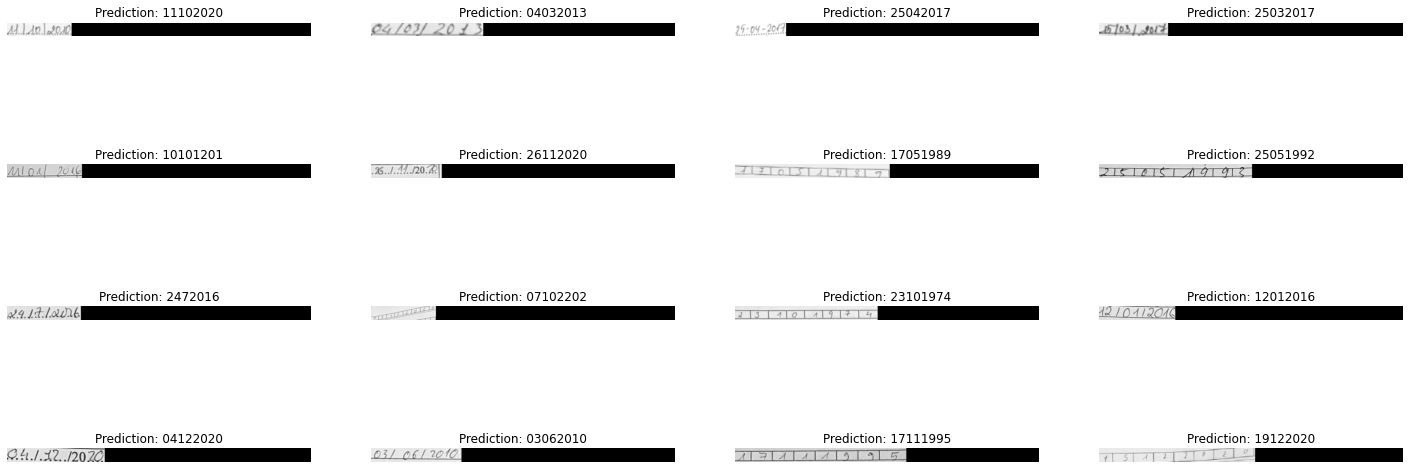

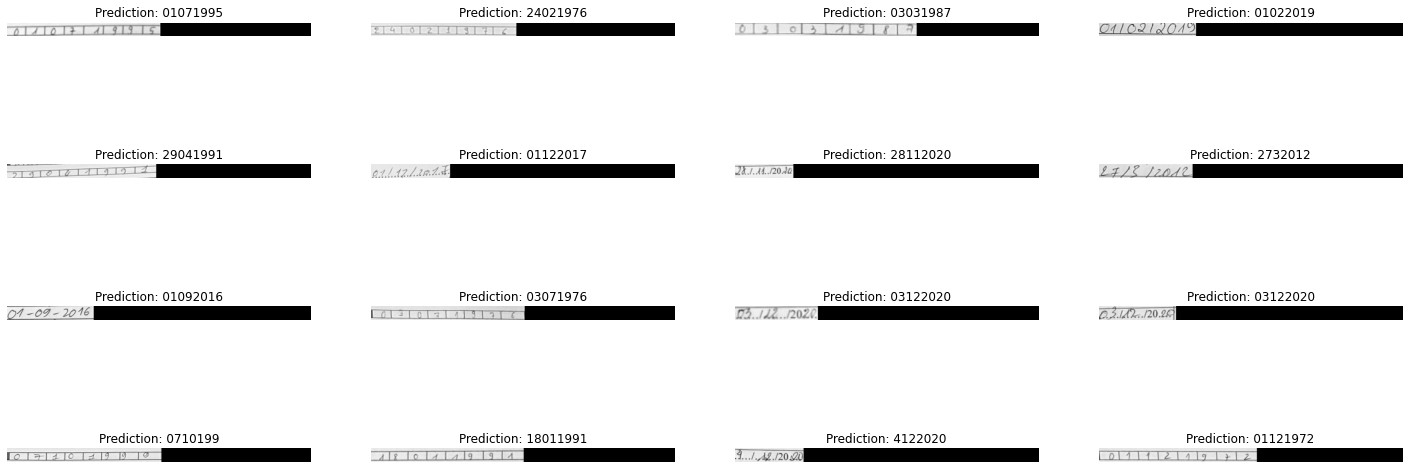

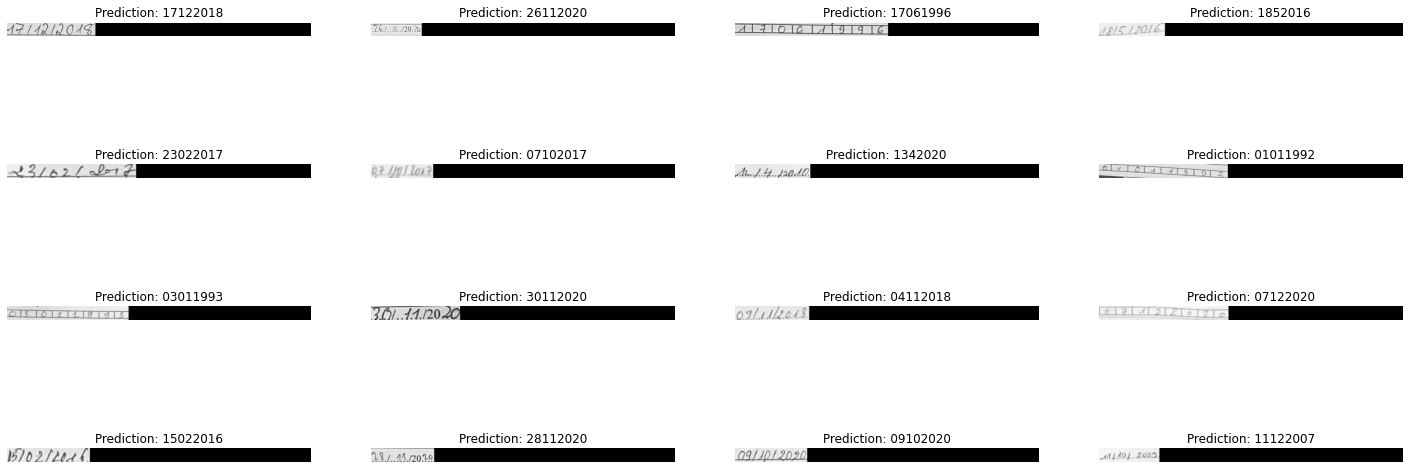

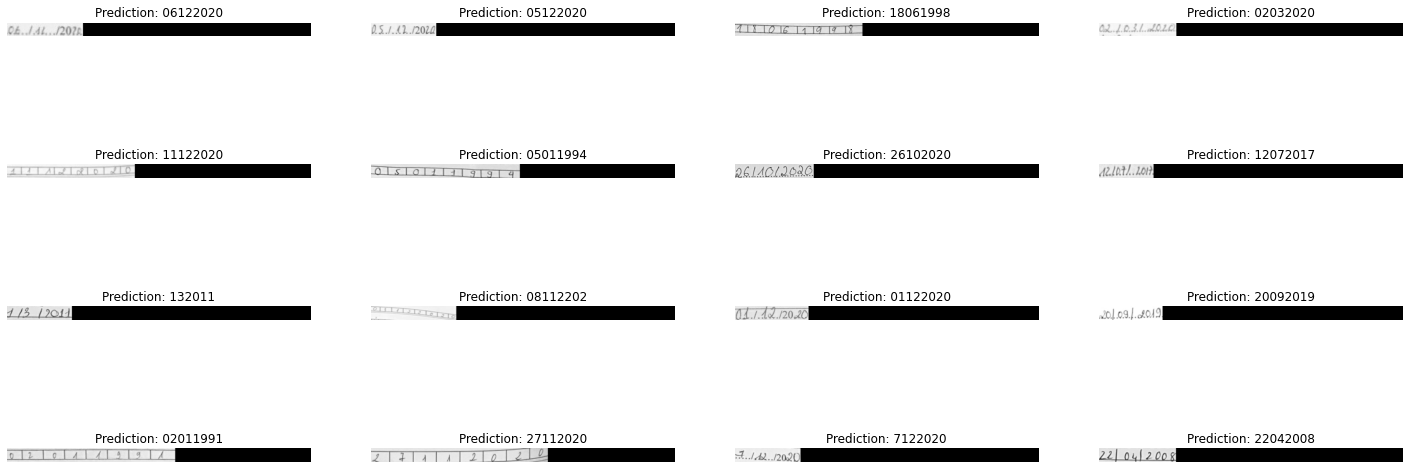

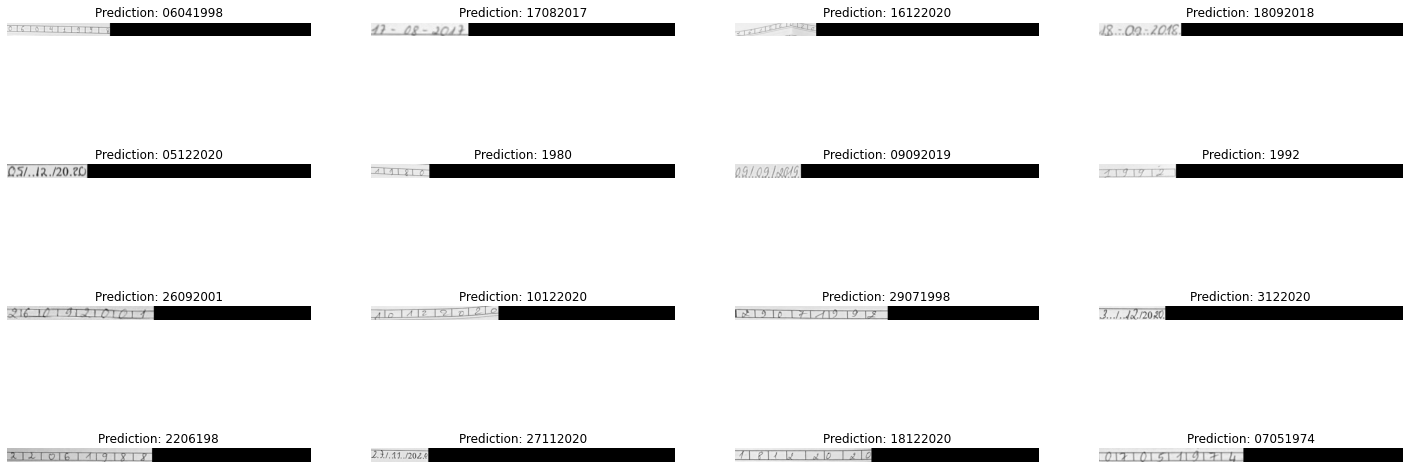

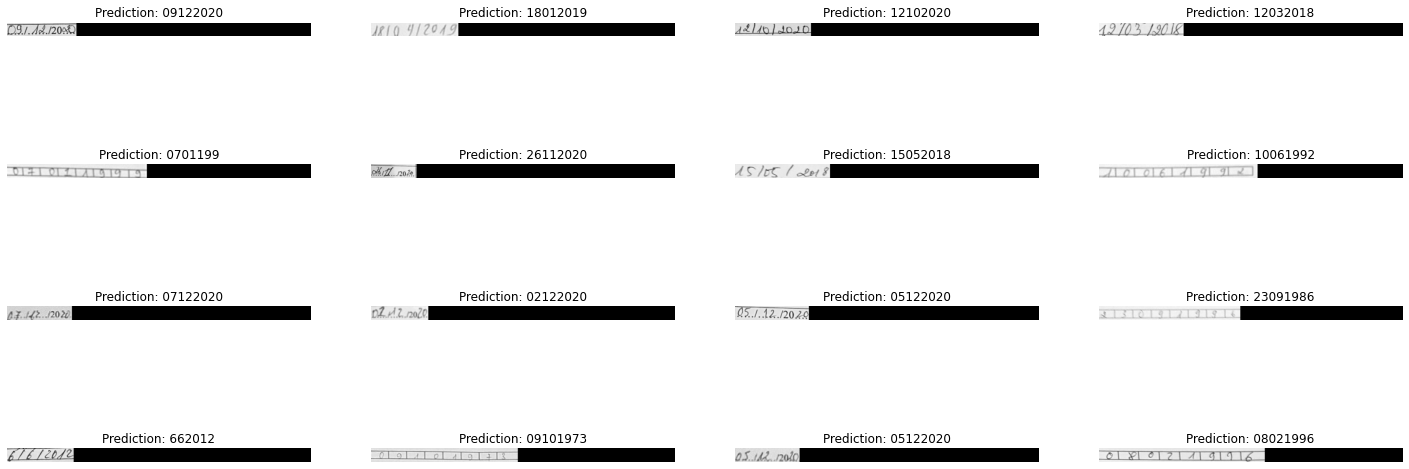

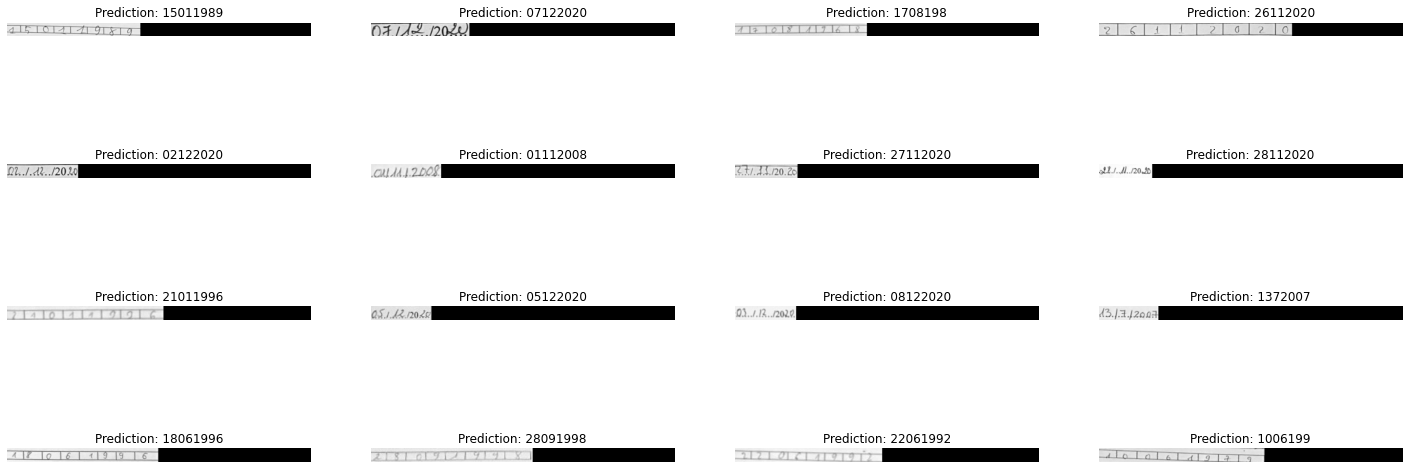

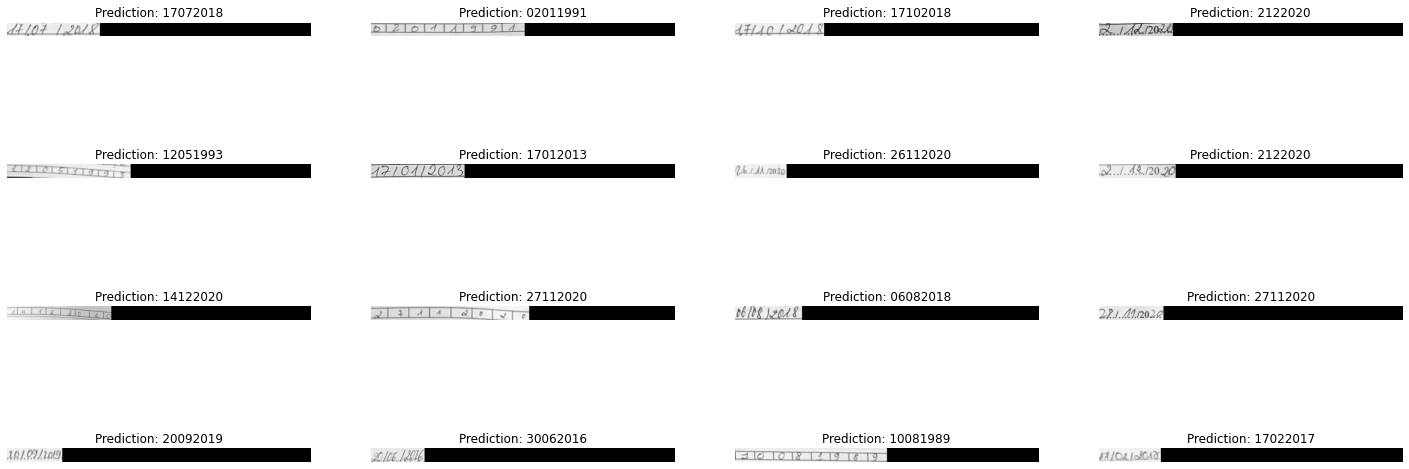

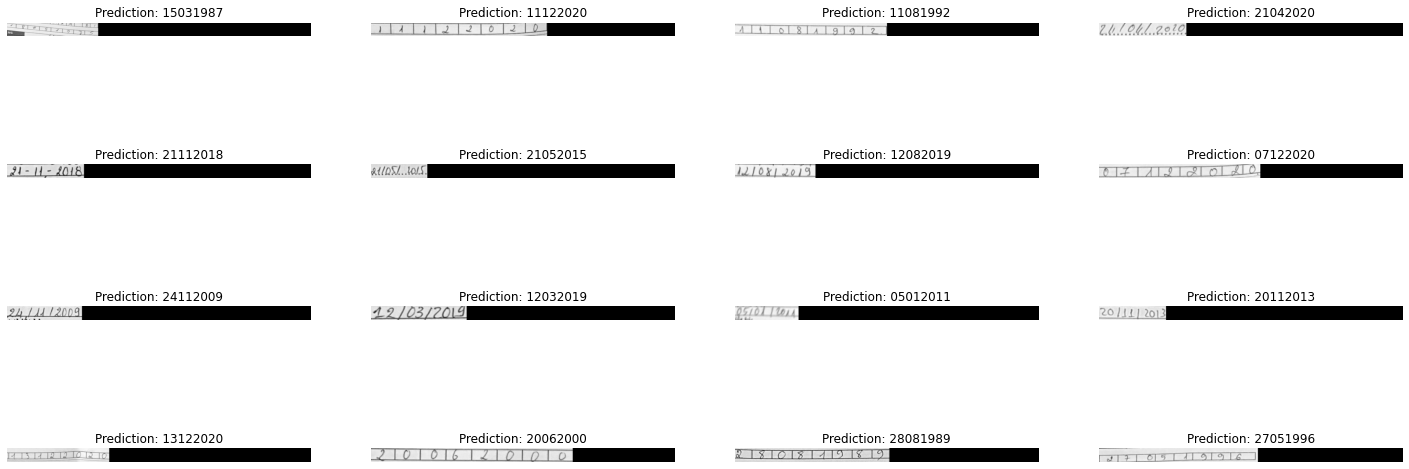

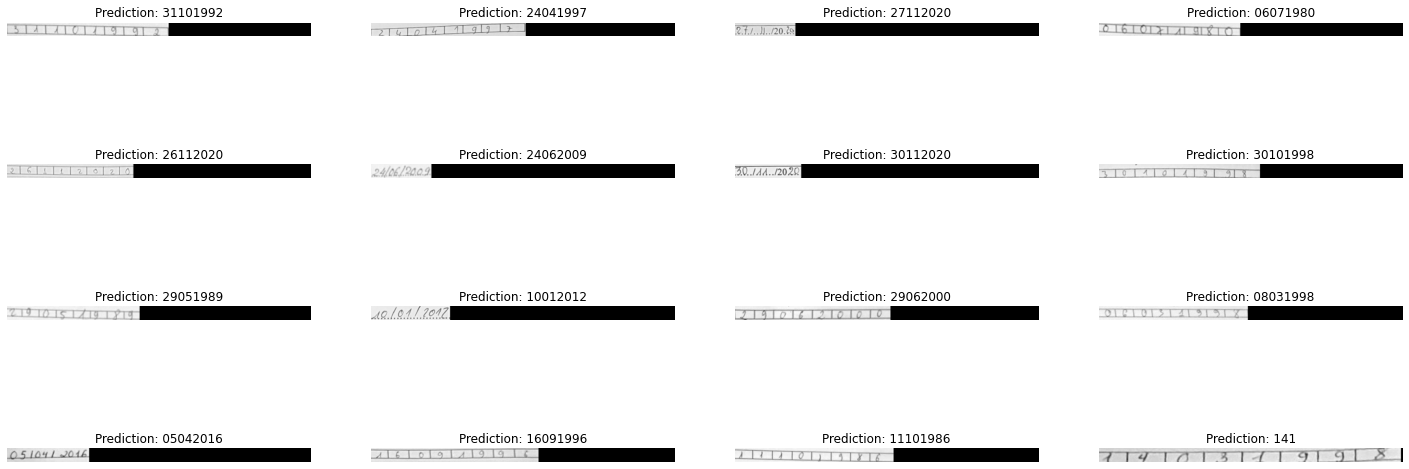

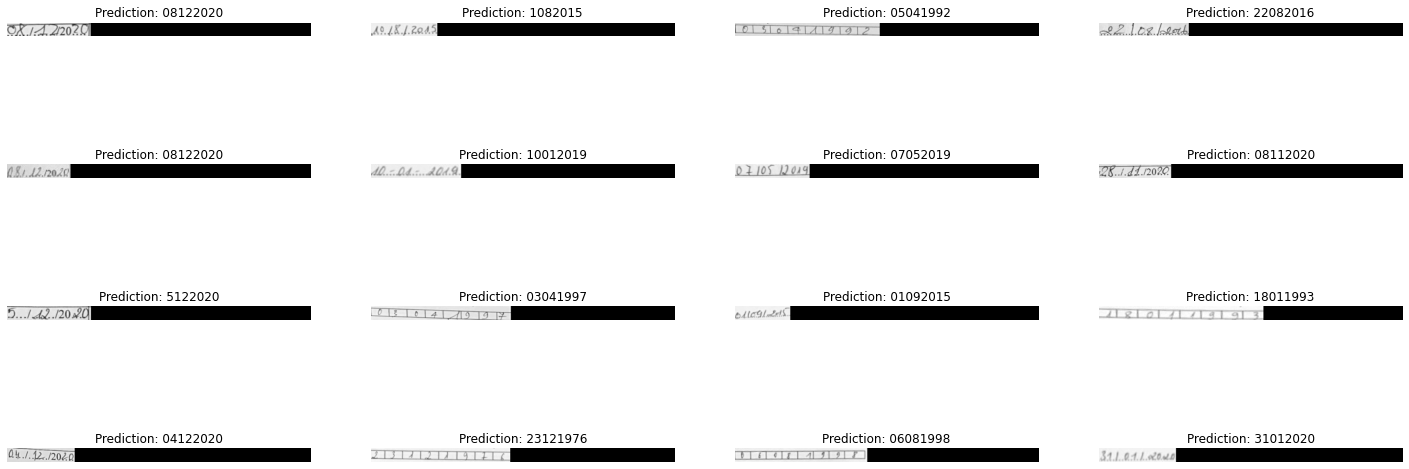

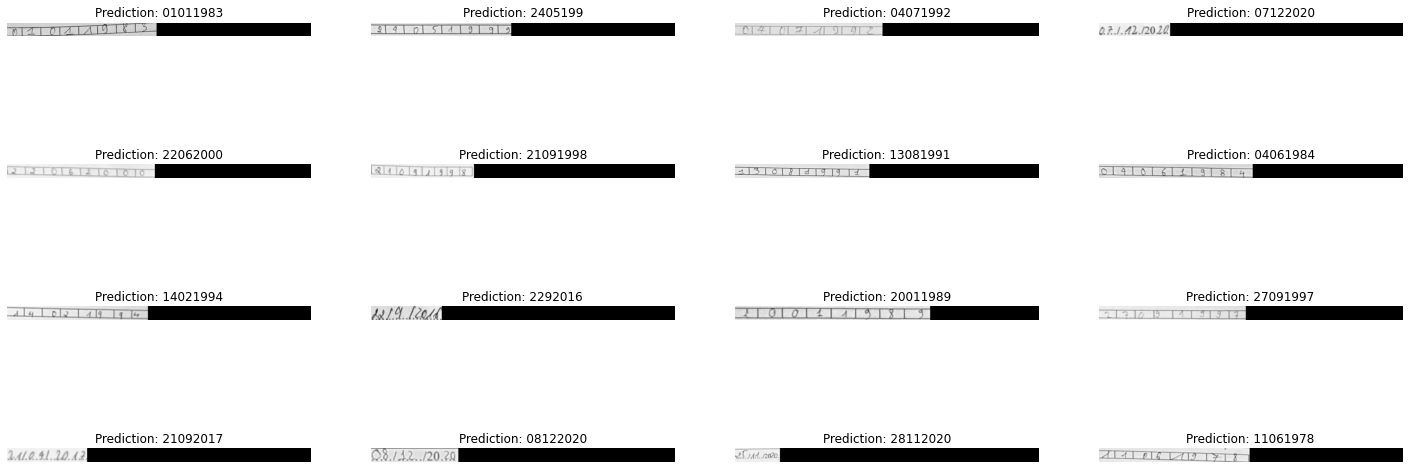

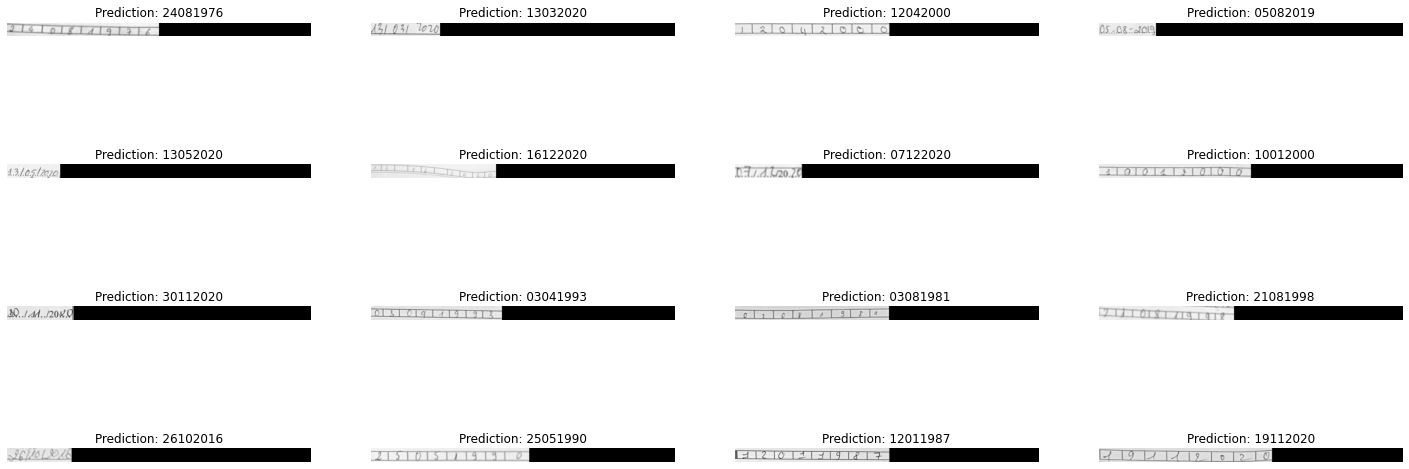

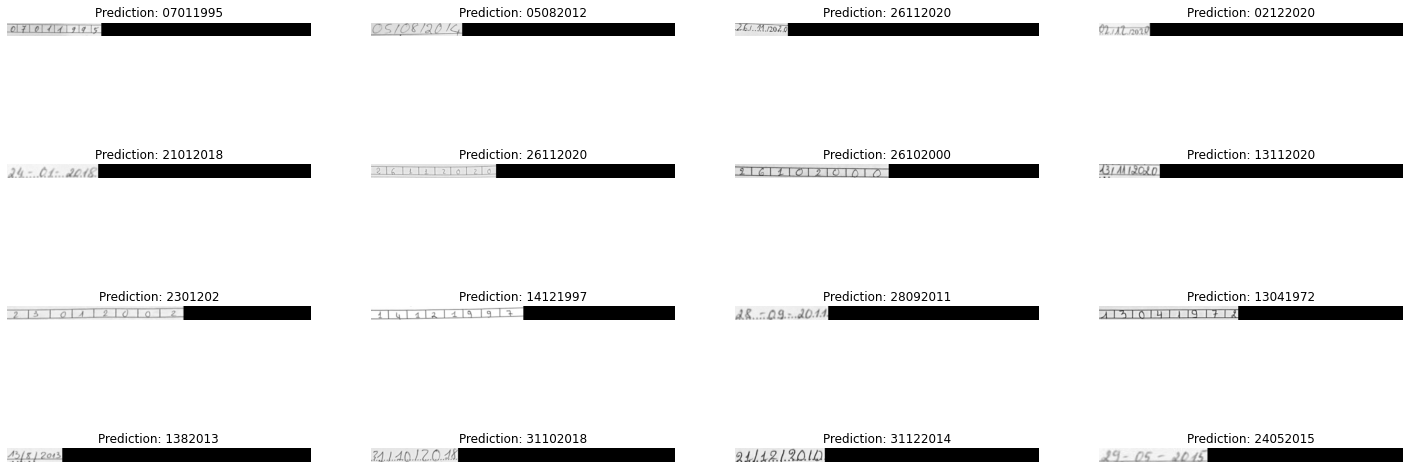

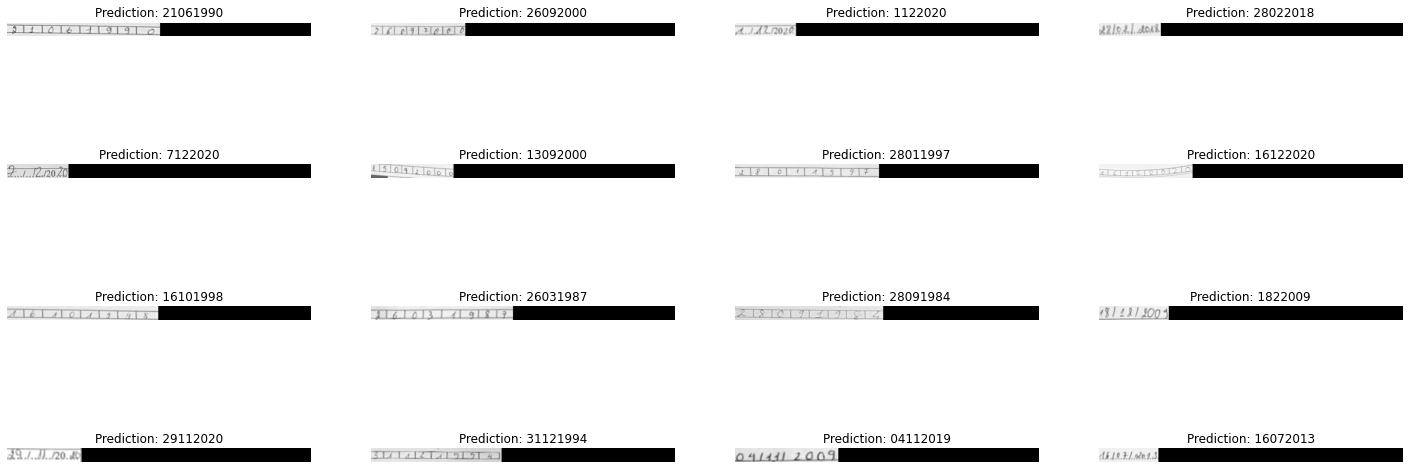

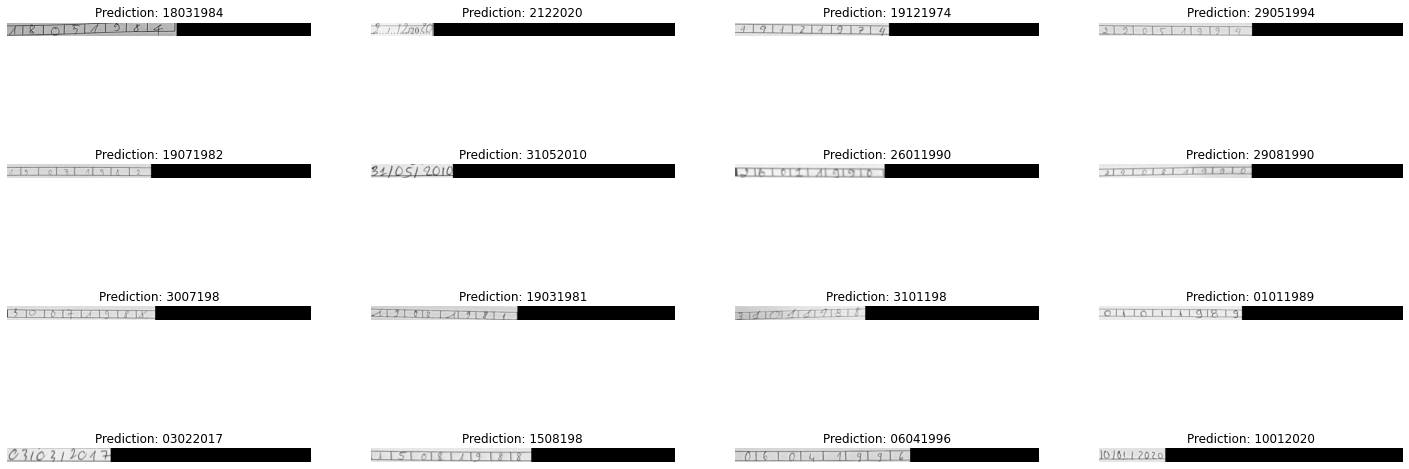

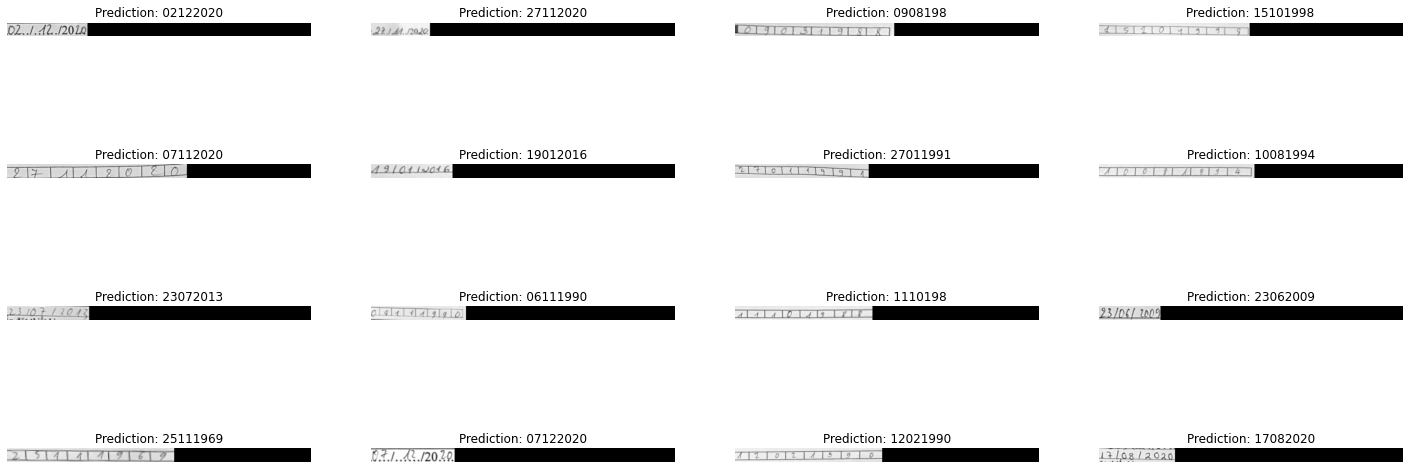

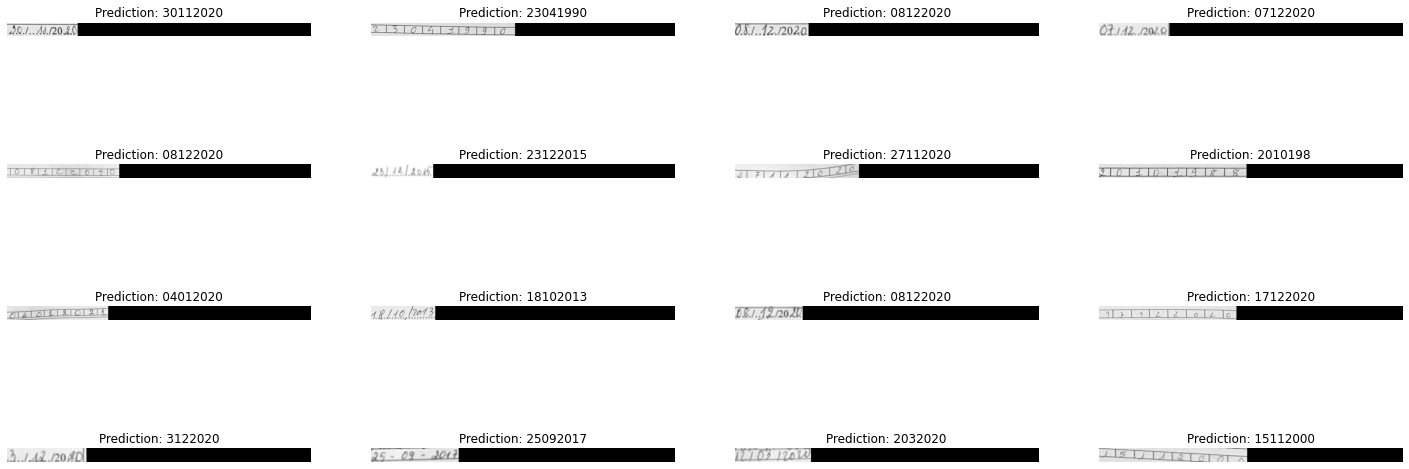

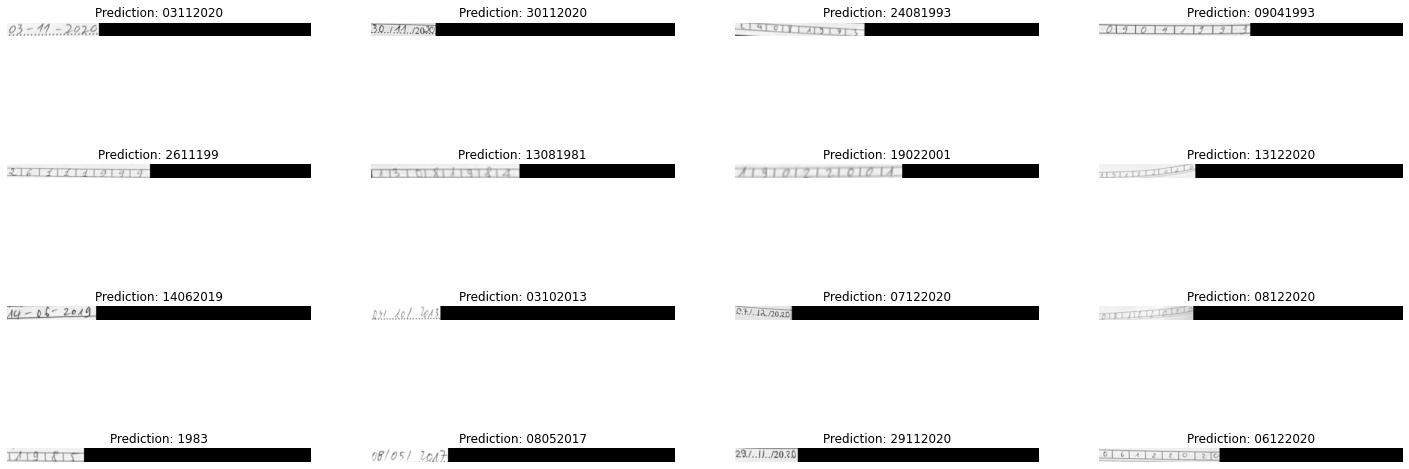

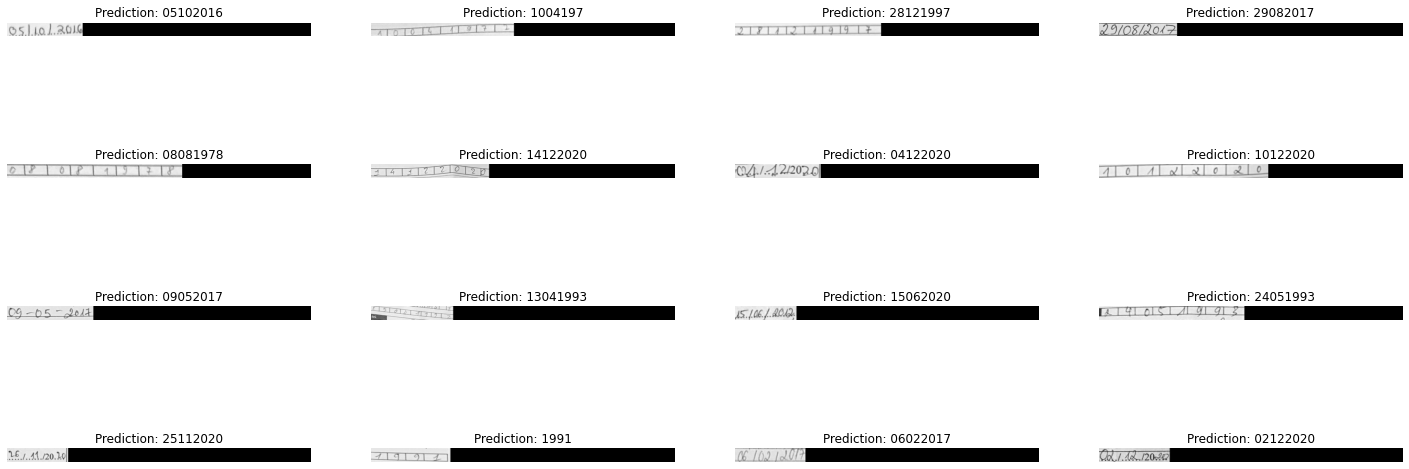

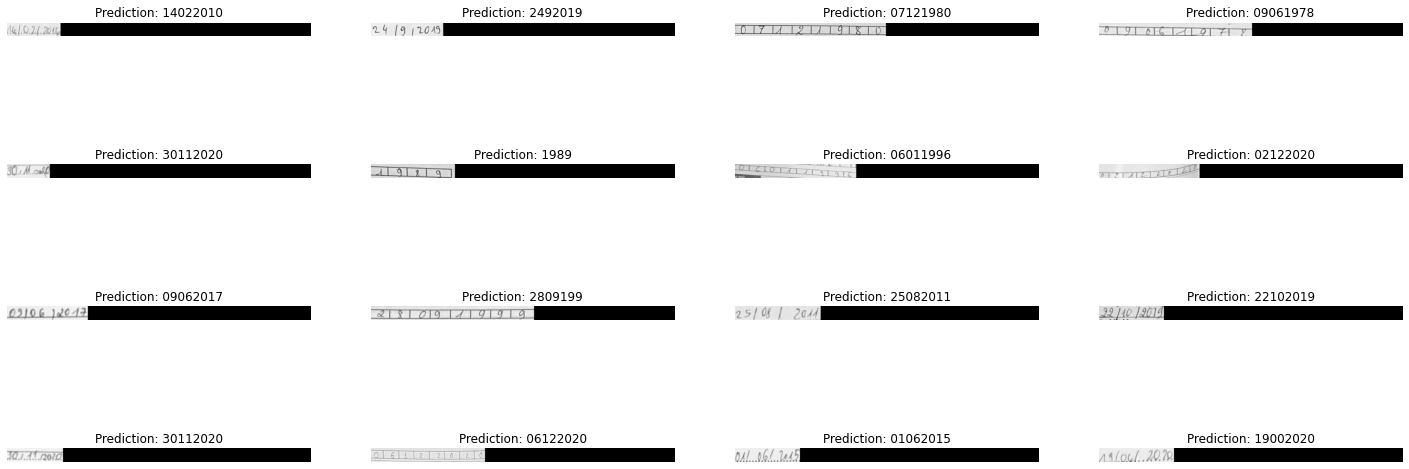

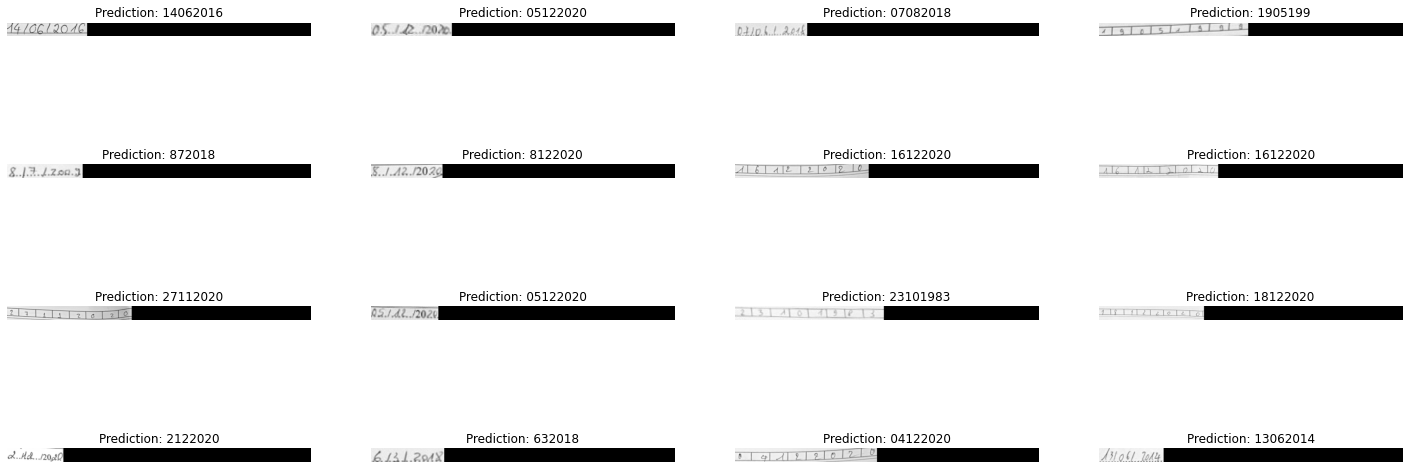

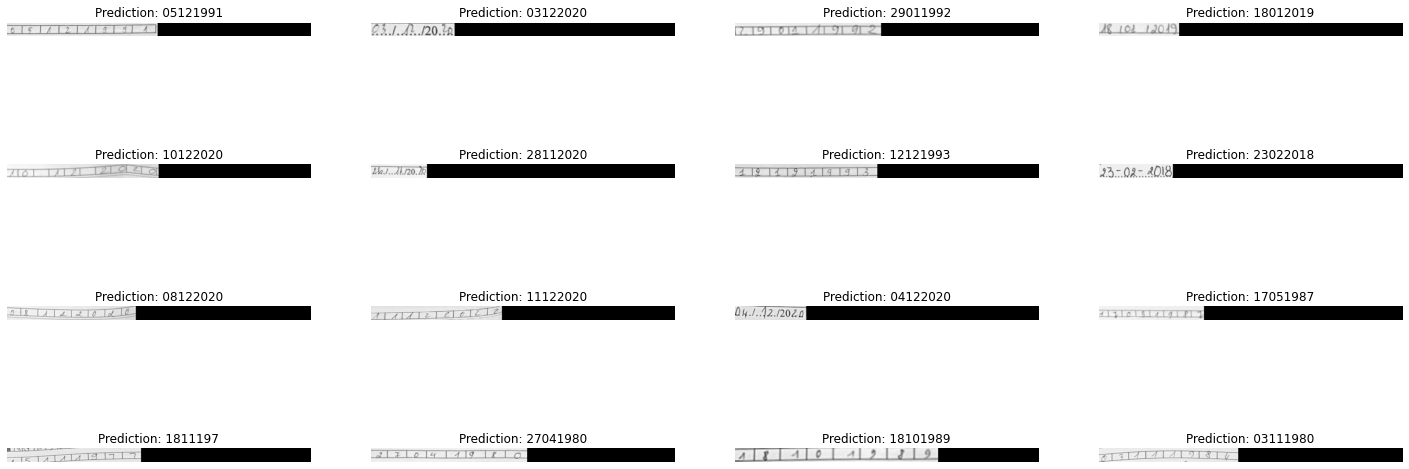

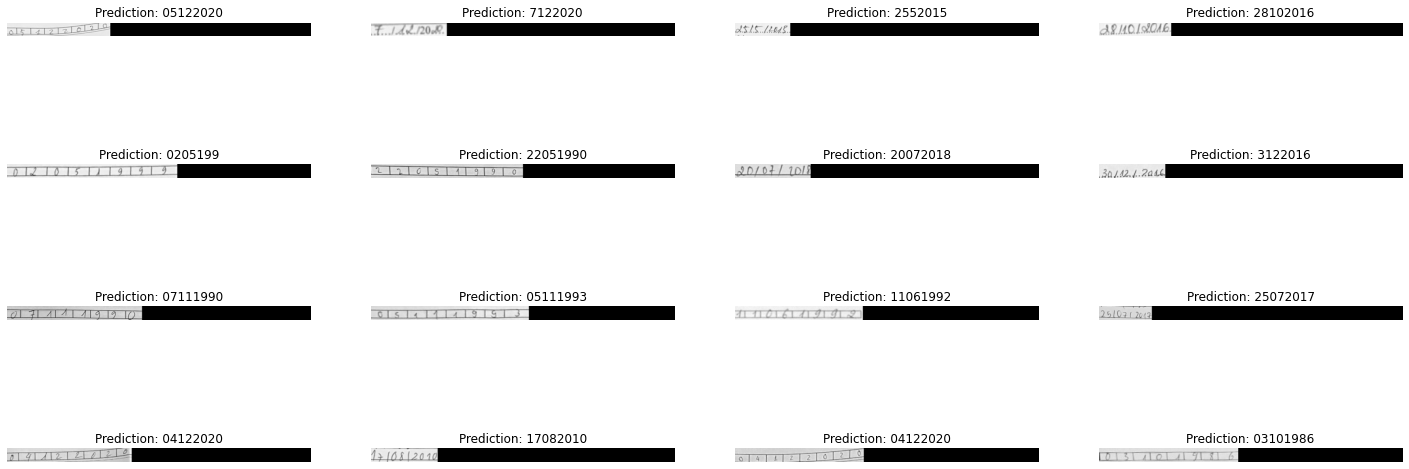

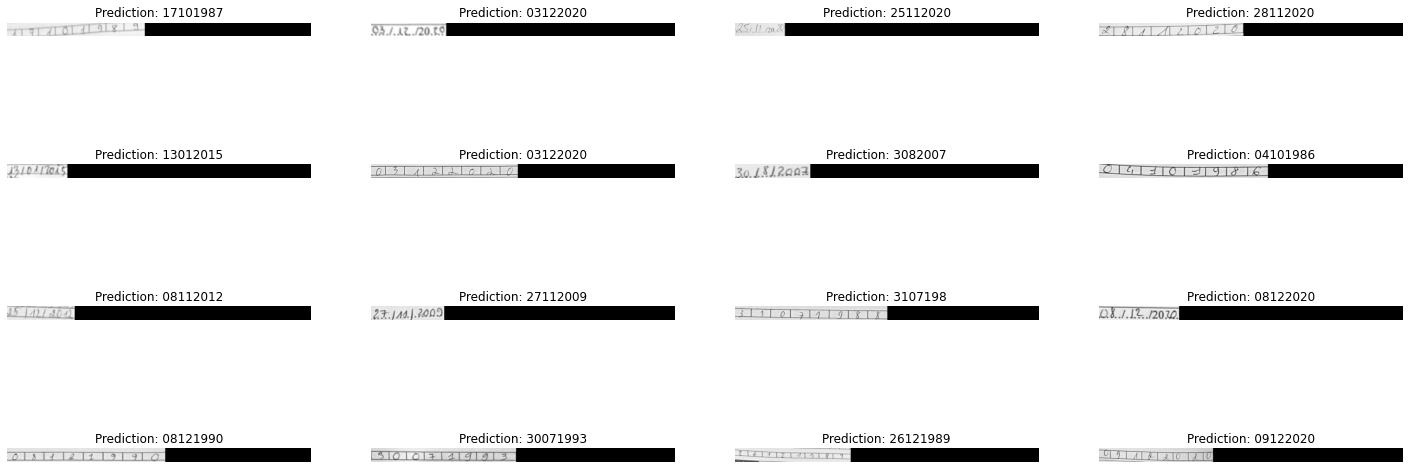

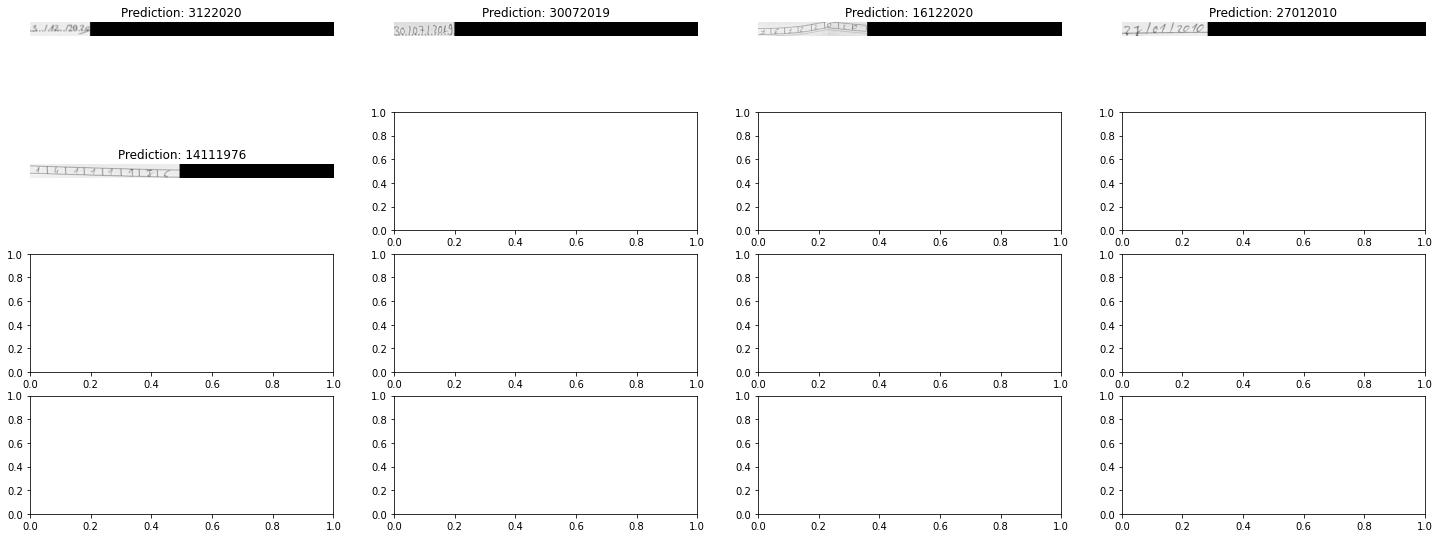

In [26]:
max_length = max([len(label) for label in labels])
# print(max_length)
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
# prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # print(pred)
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

orig_texts = []
predict = []
for batch in validation_dataset.take(50):
  batch_images = batch["image"]
  batch_labels = batch["label"]
  # print(batch_images, batch_labels)
  preds = prediction_model.predict(batch_images)
  # print(preds[0])
  # for i in range(len(preds[0])):
  #   print(max(preds[0][i]))
  #   if i == len(preds[0]):
  #     break
  pred_texts = decode_batch_predictions(preds)

  for label in batch_labels:
    
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")  
    label = label.replace(NULL_CHAR, "")
    # print(label)
    orig_texts.append(label)

  _, ax = plt.subplots(4, 4, figsize=(25, 10))

  for i in range(len(pred_texts)):
    img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
    img = img.T

    label_predict = pred_texts[i].replace("[UNK]","")
    # print(" "+label_predict)
    predict.append(label_predict)
    title = f"Prediction: {label_predict}"
    ax[i // 4, i % 4].imshow(img, cmap='gray')
    ax[i // 4, i % 4].set_title(title)
    ax[i // 4, i % 4].axis("off")
plt.show()

# print(orig_texts[0])
# print(pred_texts[0])

##Evaluated accuracy model

In [ ]:
print(orig_texts)
print(predict)

In [27]:
#words
count = 0
for i in range(len(orig_texts)):
  if orig_texts[i] == predict[i]:
    count += 1
acc = count/len(orig_texts)*100
print("Accuracy test data: " +str(acc))


Accuracy test data: 81.84568835098335


In [ ]:
for i in range(len(orig_texts)):
  if orig_texts[i] == predict[i]:
    print("Accuracy seq: 100%, (word: {})".format(orig_texts[i]))
  else:
    count = 0
    for j in range(min(len(orig_texts[i]), len(predict[i]))):
      if orig_texts[i][j] == predict[i][j]:
        count += 1
       
    print("Accuracy seq: 0%, accuracy character: {}/{}".format(count, len(orig_texts[i])))
    print("Origin text: {}, predict text: {}".format(orig_texts[i], predict[i]))

In [ ]:
#characters

for i in range(len(characters)):
  count = 0
  count_c = 0
  for j in range(len(orig_texts)):
    temp = 10
    if len(orig_texts[j]) != len(predict[j]):
      temp = min(len(orig_texts[j]), len(predict[j]))

    for k in range(min(len(orig_texts[j]), temp)):
      if orig_texts[j][k] == characters[i]:
        count += 1
        if orig_texts[j][k] == predict[j][k]:
          count_c += 1
  if count != 0:
    print('Accuracy character '+ characters[i] +': '+ str(round(count_c / count, 2)*100))
  else:
    print('Accuracy character '+ characters[i] +': '+str(count))


##CER (Character Error Rate)

In [ ]:
def dist(x, m, y, n):
  if m == 0:
    return n
  if n == 0:
    return m
  cost = 0 if(x[m - 1] == y[n - 1]) else 1
  return min(dist(x, m - 1, y, n)+1, dist(x, m, y, n - 1) + 1, dist(x, m - 1, y, n - 1) + cost)

cer = 0
for i in range(len(orig_texts)):
  x = orig_texts[i]
  y = predict[i]
  lenvenshtein = dist(x, len(x), y, len(y))
  _max = len(x)
  cer_i = lenvenshtein/_max
  cer += cer_i
  # print("cer_i: ", round(cer_i, 2), " / Acurracy",round((1-cer_i)*100, 2),"%")  

print("Accuracy: ", round((1-cer/len(orig_texts))*100, 2),"%")
